# Instructions
What files do I need?
You'll need train.csv, test.csv, and sample_submission.csv.

What should I expect the data format to be?
Each row contains the text of a tweet and a sentiment label. In the training set you are provided with a word or phrase drawn from the tweet (selected_text) that encapsulates the provided sentiment.

Make sure, when parsing the CSV, to remove the beginning / ending quotes from the text field, to ensure that you don't include them in your training.

What am I predicting?
You're attempting to predict the word or phrase from the tweet that exemplifies the provided sentiment. The word or phrase should include all characters within that span (i.e. including commas, spaces, etc.). The format is as follows:

<id>,"<word or phrase that supports the sentiment>"

For example:
    
2,"very good"
5,"I am neutral about this"
6,"bad"
8,"if you say so!"
etc.
    
    
## Files
train.csv - the training set
test.csv - the test set
sample_submission.csv - a sample submission file in the correct format
    
    
## Columns
textID - unique ID for each piece of text
text - the text of the tweet
sentiment - the general sentiment of the tweet
selected_text - [train only] the text that supports the tweet's sentiment
    
## highlight
The final outcome is not sentiment valence, but which text reflects sentiment (as in selected text)

In [1]:
import pandas as pd
import numpy as np
# !pip install sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import seaborn as sb
import matplotlib.pyplot as plt
# !pip install spacy
import spacy
# !pip install wordcloud
import wordcloud
# ! pip install nltk
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
# ! pip install tqdm
from tqdm import tqdm
import random
from spacy.util import minibatch
from spacy.util import compounding

In [2]:
train=pd.read_csv(r'/kaggle/input/tweet-sentiment-extraction/train.csv')
test = pd.read_csv(r'/kaggle/input/tweet-sentiment-extraction/test.csv')

In [3]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
print(np.shape(train))
np.shape(test)

(27481, 4)


(3534, 3)

In [5]:
print(train.dtypes)

textID           object
text             object
selected_text    object
sentiment        object
dtype: object


In [6]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
None


there is a null value for text and selected text, but there is sentiment, we can just remove it

In [7]:
train = train.dropna().reset_index(drop=True)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [9]:
# calculate jaccard simialrity
def jaccard_similarity(f_seg1, f_seg2):
    a = set(f_seg1.lower().split())
    b = set(f_seg2.lower().split())
    inter = len(a.intersection(b))
    uni =  len(a) + len(b) - inter
    return inter/uni

In [10]:
train.head(2)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative


In [11]:
jar = train.apply(lambda x: jaccard_similarity(x['selected_text'], x['text']), axis=1)
train = train.assign(jarccard = jar)

In [12]:
train.head()

,textID,text,selected_text,sentiment,jarccard
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286


In [13]:
# check jaccard similarity by sentiment valence
print(train.groupby('sentiment').mean())
print('----')
train.groupby('sentiment').size()

           jarccard
sentiment          
negative   0.338613
neutral    0.976445
positive   0.314372
----


sentiment
negative     7781
neutral     11117
positive     8582
dtype: int64

<AxesSubplot:xlabel='jarccard', ylabel='Density'>

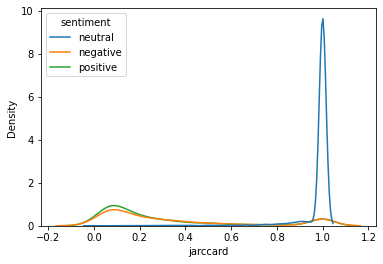

In [14]:
## it seems neutral sentiment has a very high jaccard similarity, 
## but negative and postive seem similar, lets check there distribution

sb.kdeplot( data=train, x='jarccard', hue='sentiment')

Text(0.5, 1.0, 'positive / negative')

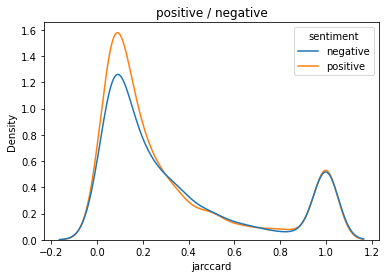

In [15]:
# take a closer look
sb.kdeplot( data=train[train.sentiment!='neutral'], x='jarccard', hue='sentiment')
plt.title('positive / negative')


In [16]:
## it seems that positive/negative jaccard similarity have two clusters, 
## one centered at around .1?, and the other is at about 1. it would be nice if we could find out patterns

low_jarccard = train[(train.sentiment!='neutral') & (train.jarccard < .2)]
low_jarccard.head()

,textID,text,selected_text,sentiment,jarccard
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,0.071429
11,16fab9f95b,I really really like the song Love Story by Ta...,like,positive,0.100000
12,74a76f6e0a,My Sharpie is running DANGERously low on ink,DANGERously,negative,0.125000
13,04dd1d2e34,i want to go to music tonight but i lost my vo...,lost,negative,0.100000


In [17]:
# check low jarccard similarity
low_jarccard.apply(lambda x: len(x.text), axis=1).describe()

count    8334.000000
mean       81.809815
std        31.763772
min         9.000000
25%        55.000000
50%        80.000000
75%       110.000000
max       141.000000
dtype: float64

In [18]:
# check high jarccard similarity
high_jarccard = train[(train.sentiment!='neutral') & (train.jarccard > .95)]
high_jarccard.apply(lambda x: len(x.text), axis=1).describe()

count    2277.000000
mean       48.706632
std        33.911741
min         5.000000
25%        22.000000
50%        38.000000
75%        67.000000
max       138.000000
dtype: float64

In [19]:
## it seems that positive/negative sentiments with high jaccard similarity tend to have less length of words in text,
## lets confirm

train = train.assign(len_T = train.apply(lambda x: len(x.text.split()), axis=1))
train = train.assign(len_ST = train.apply(lambda x: len(x.selected_text.split()), axis=1))

In [20]:
train.head()

,textID,text,selected_text,sentiment,jarccard,len_T,len_ST
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,10,2
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,5,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,5,3
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,14,3


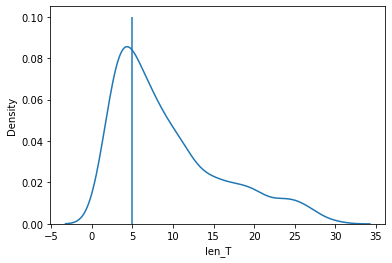

In [21]:
sb.kdeplot(data = train[(train.sentiment!='neutral') & (train.jarccard > .95)] , x = 'len_T')
plt.vlines(x=5, ymin =.0, ymax=.1)

so it seems that if word count is <= 5, 
we can just keep the text as selected text as jaccard similarity is high

#### summary for now
1. if neutral, directly use the text as selected_text
2. in pos/neg, if word count is <=5, directly use text as selected_text


In [22]:
train = train.drop(columns = 'len_ST') # as in the test, we are not able to know the value

In [23]:
train[train.len_T <=2].groupby('sentiment').mean() # can try the value 

,jarccard,len_T
sentiment,,
negative,0.788580,1.842593
neutral,0.977805,1.670702
positive,0.765700,1.777778


In [24]:
train[train.len_T <=1].groupby('sentiment').mean() # can try the value 

,jarccard,len_T
sentiment,,
negative,0.882353,1.0
neutral,0.970588,1.0
positive,0.869565,1.0


 it is interesting that if the value of length is 1, how come jaccard similarity is not 1

In [25]:
train[(train.len_T == 1) & (train.jarccard <1)]

,textID,text,selected_text,sentiment,jarccard,len_T
572,bc879a25b0,.....headache,headache,negative,0.0,1
1318,bc84f21e3b,ShoesShoesShoes.YayYayYay.lol.IWouldPostATwitP...,ShoesShoesShoes.YayYayYay.lol.I,positive,0.0,1
3723,5714d8c2c3,Goodnight.,Goodnight,positive,0.0,1
8426,cc3d762b98,Subway=yum!,yum!,positive,0.0,1
11657,515f4c5c4a,Goodnight!!!!!!,Goodnight!,positive,0.0,1
13964,9d57d8f6d6,hï¿½rlich!,rlich!,neutral,0.0,1
16641,320d33101f,goodnight!!!,goodnight!!,positive,0.0,1
22683,61d5b309ae,thanks!,thanks,positive,0.0,1
24068,bd085c659b,G`night!,G`night,neutral,0.0,1
24209,bbe7ecfac4,BYEEEEE!!!,BYEEEEE!!,neutral,0.0,1


In [26]:
train[(train.len_T <=2) & (train.jarccard < .98)]

,textID,text,selected_text,sentiment,jarccard,len_T
572,bc879a25b0,.....headache,headache,negative,0.0,1
697,2f6d9d1419,#stackeoverflow http://bit.ly/13Nfk1,#stackeoverflow,neutral,0.5,2
915,c16a52d2a7,nice clutch,nice,positive,0.5,2
1135,3113132bb5,thanks lyxxx,thanks,positive,0.5,2
1145,9bf21c82f3,Happy birthday!,Happy,positive,0.5,2
...,...,...,...,...,...,...
25796,086deb67c5,Sunburn hurts!,hurts!,negative,0.5,2
26259,cfedf94a53,"ohh, ouch",ouch,negative,0.5,2
26998,4213f65406,missing someonee...,missing,negative,0.5,2
27154,6e07eb34b4,Link !,Link,neutral,0.5,2


In [27]:
# there are links in text ? check

[i for i in train.text if 'http' in i][:10]

['http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth',
 'i`ve been sick for the past few days  and thus, my hair looks wierd.  if i didnt have a hat on it would look... http://tinyurl.com/mnf4kw',
 'Thats it, its the end. Tears for Fears vs Eric Prydz, DJ Hero   http://bit.ly/2Hpbg4',
 ' Then you should check out http://twittersucks.com and connect with other tweeple who hate twitter',
 'will be back later.  http://plurk.com/p/rp3k7',
 'mannnn..... _ got an iphone!!! im jealous....  http://bit.ly/NgnaR',
 'URL in previous post (to timer job) should be http://bit.ly/a4Fdb. I`d removed space which messed up URL.  ^ES',
 'http://twitpic.com/66xlm -  hate when my PARKED car gets hit',
 'yellow for   ? http://blip.fm/~5z05g',
 '35mins through the 1hr 20mins Google Wave demo, that looks a lot of fun, would love to test it though.  http://bit.ly/WnMSc']

In [28]:
# lets' check their selected text to see if we need to exclude those

web = train.apply(lambda x: x.selected_text if 'http' in x.text else None, axis=1)

In [29]:
with_web = train.iloc[web.dropna().index,:]
with_web.selected_text[:5]

5     http://www.dothebouncy.com/smf - some shameles...
17                                                 sick
35               Thats it, its the end. Tears for Fears
50    Then you should check out http://twittersucks....
57                                  will be back later.
Name: selected_text, dtype: object

In [30]:
selected_contain_web= with_web.apply(lambda x: x.selected_text if 'http' in x.selected_text else None, axis=1).dropna()
len(selected_contain_web)/len(with_web)

0.2878168438266558

about 1/3 does contain http in selected text, -_-!

In [31]:
train.iloc[selected_contain_web.dropna().index,:].groupby('sentiment').size()

sentiment
negative      3
neutral     346
positive      3
dtype: int64

In [32]:
train.iloc[with_web.dropna().index,:].groupby('sentiment').size()

sentiment
negative    234
neutral     580
positive    409
dtype: int64

## so it seems we could remove https:.... after 1. keep neural the same, 2. keep if len(text) <=2 in pos/neg labeled data

In [33]:
# we could check top word cloud in neutral/pos/neg word
from spacy.lang.en.stop_words import STOP_WORDS

In [34]:
train.head()

,textID,text,selected_text,sentiment,jarccard,len_T
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,10
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,14


### does selected_text have stop words and should we do stop words removal, probably should not, because selected text is a continuous part of text. but nevertheless, we could explore

In [35]:
train.head(20).apply(lambda x: [i for i in x.text.split() if i not in stopwords.words('english')], axis=1)

0                           [I`d, responded,, I, going]
1                   [Sooo, SAD, I, miss, San, Diego!!!]
2                               [boss, bullying, me...]
3                            [interview!, leave, alone]
4     [Sons, ****,, couldn`t, put, releases, already...
5     [http://www.dothebouncy.com/smf, -, shameless,...
6              [2am, feedings, baby, fun, smiles, coos]
7                                         [Soooo, high]
8                                                [Both]
9     [Journey!?, Wow..., u, became, cooler., hehe.....
10    [much, love, hopeful,, reckon, chances, minima...
11    [I, really, really, like, song, Love, Story, T...
12        [My, Sharpie, running, DANGERously, low, ink]
13             [want, go, music, tonight, lost, voice.]
14                               [test, test, LG, enV2]
15                              [Uh, oh,, I, sunburned]
16    [S`ok,, trying, plot, alternatives, speak, *si...
17    [i`ve, sick, past, days, thus,, hair, look

In [36]:
 train[train['sentiment'] =='positive']

,textID,text,selected_text,sentiment,jarccard,len_T
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,fun,positive,0.071429,14
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,Wow... u just became cooler.,positive,0.500000,10
11,16fab9f95b,I really really like the song Love Story by Ta...,like,positive,0.100000,11
21,e48b0b8a23,Playing Ghost Online is really interesting. Th...,interesting.,positive,0.043478,24
25,e00c6ef376,"the free fillin` app on my ipod is fun, im add...","the free fillin` app on my ipod is fun, im add...",positive,1.000000,11
...,...,...,...,...,...,...
27466,432e6de6c9,morning twit-friends! welcome to my new followers,welcome,positive,0.142857,7
27473,8f14bb2715,So I get up early and I feel good about the da...,I feel good ab,positive,0.130435,27
27474,b78ec00df5,enjoy ur night,enjoy,positive,0.333333,3
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,0.272727,22


In [37]:
## generate word cloud for pos/neg/neutral
pos_data = train[train['sentiment'] =='positive'].reset_index(drop=True)
neg_data = train[train['sentiment'] =='negative'].reset_index(drop=True)
neu_data = train[train['sentiment'] =='neutral'].reset_index(drop=True)

In [38]:
# a bit long to run
from collections import defaultdict

def get_all_words(df, stpwd):
    words = defaultdict()
    for i in df.apply(lambda x: x.text.lower().split(), axis=1):      
        for each_word in i:
            if each_word not in stpwd:
                if each_word not in words.keys():
                    words[each_word]=1
                else:
                    words[each_word]=words[each_word]+1
    return words

stpwrd = STOP_WORDS.union(stopwords.words('english')).union(set(['i', 'i`m','it`s','****', '&','u','-']))
pos_words= get_all_words(pos_data,stpwrd)
neg_words = get_all_words(neg_data,stpwrd)
neu_words = get_all_words(neu_data,stpwrd)



In [39]:
sorted(pos_words.items(), key=lambda k_v: k_v[1], reverse=True)[:30]

[('good', 901),
 ('day', 859),
 ('love', 836),
 ('happy', 802),
 ('thanks', 420),
 ('great', 409),
 ('like', 396),
 ('hope', 389),
 ('mother`s', 329),
 ('got', 299),
 ('nice', 282),
 ('going', 278),
 ('mothers', 278),
 ('new', 266),
 ('wish', 244),
 ('lol', 242),
 ('thank', 239),
 ('fun', 233),
 ('time', 229),
 ('night', 221),
 ('today', 201),
 ('morning', 200),
 ('work', 194),
 ('best', 188),
 ('know', 184),
 ('im', 181),
 ('better', 178),
 ('think', 174),
 ('haha', 173),
 ('don`t', 169)]

In [40]:
sorted(neg_words.items(), key=lambda k_v: k_v[1], reverse=True)[:20]

[('like', 464),
 ('miss', 422),
 ('im', 348),
 ('don`t', 336),
 ('can`t', 328),
 ('going', 326),
 ('got', 317),
 ('work', 309),
 ('feel', 282),
 ('sad', 280),
 ('sorry', 264),
 ('hate', 261),
 ('bad', 245),
 ('want', 237),
 ('day', 237),
 ('know', 226),
 ('think', 217),
 ('oh', 198),
 ('need', 181),
 ('today', 179)]

In [41]:
sorted(neu_words.items(), key=lambda k_v: k_v[1], reverse=True)[:20]

[('going', 458),
 ('got', 453),
 ('like', 443),
 ('day', 385),
 ('work', 375),
 ('know', 347),
 ('don`t', 345),
 ('lol', 336),
 ('time', 335),
 ('want', 319),
 ('new', 313),
 ('im', 295),
 ('2', 275),
 ('think', 265),
 ('need', 264),
 ('good', 260),
 ('today', 259),
 ('can`t', 259),
 ('home', 250),
 ('i`ll', 195)]

In [42]:
def generate_word_cloud(df, label, sw):
    my_cloud = wordcloud.WordCloud(background_color='white',
                                   stopwords= sw, 
                                   max_words=50,
                                   width=200*5,
                                   height=120*5,
                                   prefer_horizontal=.95).generate_from_frequencies(df)
    # Display the generated wordcloud image
    plt.imshow(my_cloud, interpolation='bilinear') 
    plt.axis("off")
    plt.title(label)
    # Don't forget to show the final image
    plt.show()
    return 

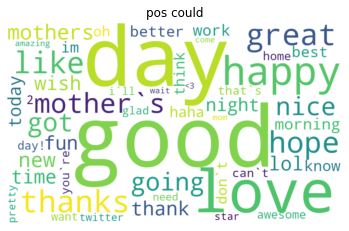

In [43]:
 generate_word_cloud(pos_words, 'pos could',stpwrd)

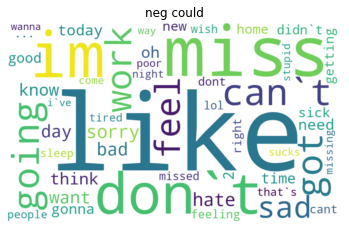

In [44]:
 generate_word_cloud(neg_words, 'neg could', stpwrd)

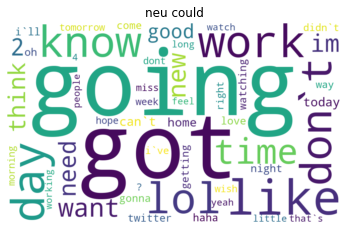

In [45]:
 generate_word_cloud(neu_words, 'neu could',stpwrd)

In [46]:
# common words used in pos/neg have a big overlap. probably we could look at bi-grams/ 

In [47]:
train

,textID,text,selected_text,sentiment,jarccard,len_T
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,10
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,14
...,...,...,...,...,...,...
27475,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative,0.058824,16
27476,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative,0.083333,23
27477,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive,0.272727,22
27478,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive,1.000000,6


## modelling

as summerized, 
1. neutral just use text as selected text
2. if text words <= 3, use texte as selected text


In [327]:
from sklearn.model_selection import train_test_split
from spacy.training.example import Example
import os

print(len(train))
train_update = train[(train['sentiment']!= 'neutral') & (train['len_T']>=3)]
print(len(train_update))

27480
16048


In [329]:
def get_train_data(df, sentiment):
    train_data = []
    for index, row in df.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text
            start = text.find(selected_text)
            end = start + len(selected_text)
            train_data.append((text, {"entities": [[start, end, 'selected_text']]}))
    return train_data
    
train_final_pos = get_train_data(train_update, 'positive')  
train_final_neg = get_train_data(train_update, 'negative')  

In [330]:
train_final_pos[0]

('2am feedings for the baby are fun when he is all smiles and coos',
 {'entities': [[30, 33, 'selected_text']]})

In [377]:
def save_model(output_dir, nlp, new_model_name):
    if output_dir is not None:        
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        nlp.meta["name"] = new_model_name
        nlp.to_disk(output_dir)
        print("Saved model to", output_dir)
        
        
def train_data(list_data, output_dir, model_name, model=None):
    # add labels
    
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
        nlp.resume_training()
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")     
        ner = nlp.create_pipe("ner")
        nlp.add_pipe('ner', last=True)  
        
        for _, annotations in list_data:
            for ent in annotations.get("entities"):
                ner.add_label(ent[2])
      
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    
    with nlp.disable_pipes(*other_pipes):  # only train NER
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()

    for itn in tqdm(range(2)):
        random.shuffle(list_data)
        batches = minibatch(list_data, size=compounding(10.0, 500, 1.001))    
        losses = {}

        for batch in batches:
            example = []
            for text, annot in batch:
                doc = nlp.make_doc(text)
                case = Example.from_dict(doc, annot)
#                 example.append(case)
#               model.update([example], sgd=optimizer, losses=losses)
                  
                nlp.update([case],
                            drop=0.6,   
                            losses=losses, 
                          
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, model_name)
    return nlp

In [379]:
nlp_model_pos = train_data(train_final_pos, '/kaggle/input/output/pos/', 'overall_pos', model=None)

Created blank 'en' model


  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "aww  you are too kind!! Hi sweetie! Are you guys o..." with entities "[[0, 120, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yes, dahling... you are definitely one awesome tw..." with entities "[[66, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 82.45122422277927}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " morning Newt...hope you are well!" with entities "[[14, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text ": just had my debut on Thursday @ The Gallery Loun..." with entities "[[61, 66, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 123.8923064423725}
Losses {'ner': 144.09811651532345}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Good night everyone...... Time to go mimmiz......" with entities "[[0, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " be clear, I am Catholic, but wholeheartedly agree..." with entities "[[28, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\

Losses {'ner': 157.55018510596057}
Losses {'ner': 177.0684219461154}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " its my birthday too  but its the 10th of may righ..." with entities "[[98, 105, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 195.31455512924742}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " he`ll be 3 in july! I`m just soo stoked!!!!  Espe..." with entities "[[32, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 213.42040859167992}
Losses {'ner': 232.73256711464728}
Losses {'ner': 252.94046733828964}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Then you might enjoy this one too  http://tinyurl..." with entities "[[14, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 270.66983255790274}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ben and Jerry...yummmmy!!!" with entities "[[16, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 288.32844625364436}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I cried like a baby when we had to put our cat do..." with entities "[[1, 100, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 305.9708285643786}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ooo thanks for the danger radio link  loves it......" with entities "[[1, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Listening to my favourite song... ALLAH KE BANDE H..." with entities "[[0, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 321.78506925306885}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hehe i will never thorw out these shoes  i`m list..." with entities "[[1, 118, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I love my daddy, but I don`t want to go to his hou..." with entities "[[0, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 337.8272411178003}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oh gaha no of course i wasn`t offended why would ..." with entities "[[59, 65, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Just amazes the heck out of me still....this 'in..." with entities "[[5, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 351.17054910420404}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Walaikum assalam...  Alhamdulillah... I`m in Chic..." with entities "[[101, 107, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 368.88469194257397}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Good morning World   This will be another wonderfu..." with entities "[[40, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Busy week this week; quick trip to chase some oil ..." with entities "[[95, 106, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 382.1276418691732}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Man with a great sense of humour... Venky Pachad?" with entities "[[0, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "The nocturnal serendipity... Kashmir is an importa..." with entities "[[14, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 397.50512167698946}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m an incredibly happy person with 100% energy. L..." with entities "[[0, 74, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hey!  YAY! thanks!  wow ur page is awesome!!!!!" with entities "[[18, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 411.32782593062404}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i saw a piece of that movie...loved it" with entities "[[29, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 429.21232187978296}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " whooop! you got me on twitter!!  dang our line of..." with entities "[[69, 78, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 446.9349472592973}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Thank you - If you like please leave a comment an..." with entities "[[78, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 464.8811736951999}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know   It was worth a shot, though!" with entities "[[14, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " It`s easy.....just turn your keyboard upside down" with entities "[[6, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\

Losses {'ner': 476.998336157931}
Losses {'ner': 496.27754748908376}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Anyone with big fingers  But I`ve loved it..." with entities "[[28, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 513.3081965228325}
Losses {'ner': 533.2272909892349}
Losses {'ner': 553.0947059247414}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Good days with good friends make me not regret liv..." with entities "[[0, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 570.8926287692128}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "can u believe the architect who planned a tar-blac..." with entities "[[0, 110, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 587.6479474223643}
Losses {'ner': 607.0155350371433}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " maybe she`s funny like a jester" with entities "[[11, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 624.6225070190067}
Losses {'ner': 644.1405116007378}
Losses {'ner': 663.4786809887615}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ahahahaha you love Twilight don`t liee!!!  and we..." with entities "[[58, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 680.3053659537122}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ok  i kinda thought so... i mean those 2? ... it ..." with entities "[[57, 64, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Last day of holydays, gotta get back to work    An..." with entities "[[56, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 697.726885758449}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  glad your feeling abit better!  I think mine mig..." with entities "[[23, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Cool Sound!! Luv 'Drama', 'Love Game' doesn`t wor..." with entities "[[73, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 709.8326327261764}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "heyyy where`d my tweet go?  *shouts to  bc her lis..." with entities "[[55, 71, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Up is out?  I didn`t get the memo   It looks amaz..." with entities "[[33, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 727.6321632028018}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " if i can buy sleep for you, i will... that`s what..." with entities "[[29, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 743.7326665388103}
Losses {'ner': 763.1629108733172}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just finished The Village. So in love,could watch ..." with entities "[[33, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 780.7425095845668}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Wow.  is constantly ranting about his love for Ge..." with entities "[[37, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " It will be an Adventure!  Have FUN with your 5 yr..." with entities "[[83, 112, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 796.5297493899598}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Football session after this.fun" with entities "[[28, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 813.93211813933}
Losses {'ner': 833.8368693060061}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " http://twitpic.com/4ukqe - haha cute and beautifu..." with entities "[[26, 67, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 851.691188677417}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aww  I wish there was sun out here. Then I can ge..." with entities "[[3, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "another fun night!!  chilled wit my homie @ green ..." with entities "[[70, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 867.5038967382221}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " her son is 7 and captured it outside...THANK GOD ..." with entities "[[39, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Printing from Opera gives me a much better result ..." with entities "[[20, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 883.5151640017875}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "hearing the birds chirp makes me think its nice ou..." with entities "[[43, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " It has, however, got me out of doing the gardenin..." with entities "[[72, 96, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 901.0218492094361}
Losses {'ner': 918.9280618186913}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hey lovely.. hope you had a good day  Thanks for ..." with entities "[[5, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 936.2650552147762}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ****, so many good deals...you guys have a conspi..." with entities "[[7, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " as to sleeping with whom ? You have your rocking ..." with entities "[[91, 119, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 951.4592097446377}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "up and reading the (maltese) sunday newspaper over..." with entities "[[69, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 969.1076358609548}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   you guys were absolutely amazing tonight, as al..." with entities "[[25, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " two macaroons go into a bar....one says oh your a..." with entities "[[2, 4, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 983.7831542401045}
Losses {'ner': 1003.2391025971096}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " the pictures tells me me that u were surrounded b..." with entities "[[50, 70, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Wooops! Meant I agree with Boomstone..trying 2 re..." with entities "[[59, 100, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1018.0472912711925}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aw its okay tht happened wid me too..am so glad t..." with entities "[[88, 124, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " tell everybody i said happy mothers day!  love ya..." with entities "[[21, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 1034.1136009715153}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  anything I can do to help?" with entities "[[21, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1048.3748633875518}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " right on!  i`m 29 myself... i turn 30 in october...." with entities "[[83, 92, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1065.7210744985348}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "wellllll, I did most of my homework. and i kind of..." with entities "[[74, 97, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " wow that is a great list... Now i need to shop" with entities "[[1, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1081.168554162639}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "on our way home after seeing Rodney Atkins in conc..." with entities "[[55, 78, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1100.7930594953934}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Well thank you darling...it was a pleasure shoppi..." with entities "[[25, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1119.2040096444007}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Presentation went well  Yes, I also met a buch of..." with entities "[[46, 120, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1136.7764993769888}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Wave looks interesting. http://bit.ly/pvYYh  If we..." with entities "[[0, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1153.787111232008}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Don`t fall to celebrity worship, though... just w..." with entities "[[76, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  that would mean me babe! but **** it my name  is..." with entities "[[62, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1170.8928273467973}
Losses {'ner': 1190.4639221945367}
Losses {'ner': 1208.9329052515682}
Losses {'ner': 1228.359220354284}
Losses {'ner': 1245.9274780225564}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Thanks   Our little girl just loves animals so al..." with entities "[[81, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hmm... it`s a miracle you`re using twitter, and i..." with entities "[[49, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 1260.3593752760428}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "http://twitpic.com/4wc1y - Cracking myself more & ..." with entities "[[76, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1276.6437710693835}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Zen-related stuff: 'Go with the flow.' Very easy t..." with entities "[[35, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1294.0990357359328}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   me too.  it depresses me thinking about it." with entities "[[12, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1310.6940908059676}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Thanks Amy!  That video is so awesome!  Did you s..." with entities "[[60, 69, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " so excited for you and Paris ooh lala  i look for..." with entities "[[85, 93, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1326.676648199755}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "love it when jonas brothers are in the trending to..." with entities "[[0, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "#followfriday     follow these ppl ... they are in..." with entities "[[33, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1344.3837491846825}
Losses {'ner': 1360.772409366098}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "everyone follow  and  ! they are amazing" with entities "[[31, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just been out to try to catch a swarm, gone into a..." with entities "[[88, 109, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-pa

Losses {'ner': 1373.3660196237272}
Losses {'ner': 1390.4054505906058}
Losses {'ner': 1408.4331151609374}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I just started watching 30 Rock too, borrowed sea..." with entities "[[77, 83, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "morning all   will be at Warner soon! lots to do, ..." with entities "[[82, 117, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1423.849282094182}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "loves it that the first Monday of May is a Bank Ho..." with entities "[[0, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1441.0316212492435}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aww  but typing from beyond the grave...impressiv..." with entities "[[39, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is so  just made a card 4 my mom!!   can`t wait to..." with entities "[[37, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1455.5015958778242}
Losses {'ner': 1473.5756255232761}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You`re welcome... and you`re welcome!" with entities "[[8, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1491.5270069406674}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Tom! Do a tour in the Philippines, please?  That ..." with entities "[[60, 69, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1508.8445124690084}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aww sweetie  you could always take a break and re..." with entities "[[70, 108, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1526.8185222528373}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Also with the not driving part i could afford a la..." with entities "[[92, 99, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "There are some great honey based recipes for you &..." with entities "[[15, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1540.4583561800519}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yay! I too had some joy in that department" with entities "[[19, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " you`ll be fine  don`t worry ... good luck again" with entities "[[9, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1583.8772267512422}
Losses {'ner': 1601.5564361762674}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " - not early at all, just say you are running on e..." with entities "[[74, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1617.8871985733892}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Were you able to watch it online?!  I hope you we..." with entities "[[62, 94, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1633.6671413573415}
Losses {'ner': 1650.2238985347249}
Losses {'ner': 1669.319525048656}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Smiling!  These guys are!    Turn up your speakers..." with entities "[[57, 71, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1685.391153275986}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " wellll...... only 2 that will feed me   the other..." with entities "[[61, 95, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1699.9265675105912}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " And so very you.  You know I say it w/ nothing bu..." with entities "[[50, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  i hope you hoes are having so much fun...not TOO..." with entities "[[35, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 1714.3165014435967}
Losses {'ner': 1734.5463396402429}
Losses {'ner': 1753.009719469679}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " My original non-Yahoo acc. was deleted when they ..." with entities "[[73, 86, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " That`s a relief! I feel better knowing it`s hered..." with entities "[[61, 66, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 1768.8956621847801}
Losses {'ner': 1790.5313768782728}
Losses {'ner': 1809.6087989720547}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " didn`t make it to 1000 but I smoked her.  She`s a..." with entities "[[69, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " thanks for the ok ...hope we can tweet more down ..." with entities "[[21, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 1823.1482818101695}
Losses {'ner': 1845.5359433642232}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  alright...I`m going to get off comp now, go back..." with entities "[[76, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1863.9310914556156}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You`re right....I`m 29 and  I`ve heard the song a..." with entities "[[1, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1881.791687299849}
Losses {'ner': 1902.6331281012328}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Jane Austen`s books!,    Pride and Prejudice & E..." with entities "[[22, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`M A JUMP OFF A BRIDGE... NOT REALLY, BUT I WANT..." with entities "[[96, 113, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 1915.774232869814}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " No. That would be too easy. All I have is the use..." with entities "[[17, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "C-News wasn`t as bad as I expected... could have d..." with entities "[[54, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1931.0380297605216}
Losses {'ner': 1950.243854217368}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Okay, no more driving.  I know... I know... you a..." with entities "[[43, 73, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1969.4060174146769}
Losses {'ner': 1987.6474766581857}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  He`s awesome... Have you worked with him before?..." with entities "[[5, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Something strange in the air lately. Been setting ..." with entities "[[82, 89, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2004.2677885017101}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ayy.  Okayyy. It was nice seeing you kanina ! :> ..." with entities "[[20, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2022.2130080160587}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You are extremely clever my dear." with entities "[[7, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " haha..yeah..10th of May..lol..im greeting in adva..." with entities "[[30, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2037.313996396485}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "You make me happy, whether you know it or not  <3" with entities "[[0, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yea i just got outta one too....i want him back t..." with entities "[[82, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2053.13381541303}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " we keep getting pet days  but i heard the weekend..." with entities "[[58, 63, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " No but I just checked and got it LOL. You are ok!..." with entities "[[32, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 2066.892225494343}
Losses {'ner': 2086.779511603883}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Feeling really good about my performance on the AP..." with entities "[[8, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i`m just sooo in love....i think" with entities "[[9, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2102.536935719616}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   woooooo im seeing you in glasgow when you come,..." with entities "[[3, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh no!! I hope it`s not bad" with entities "[[19, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2116.9723299289158}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is so excited for this summer... Steve Winwood and..." with entities "[[0, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  yahyan:  iaaaaaaaaaaaaan, i was just joking" with entities "[[36, 44, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site

Losses {'ner': 2131.6616797177126}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "didn`t make it out to shop.......      there is al..." with entities "[[39, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2149.3614751772598}
Losses {'ner': 2169.984966391441}
Losses {'ner': 2207.3071464881086}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Good Luck.. mine 3rd day today !" with entities "[[1, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2223.87713506807}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Happy Mother`s Day everyone." with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2243.6752475412104}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " No I LOVE Jordie`s version as well as Joe`s and D..." with entities "[[2, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " it is, and its shiny and if i could marry it i wo..." with entities "[[61, 67, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2262.8000764771537}
Losses {'ner': 2282.2802795200278}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  that`s no bueno...hope u feel better!" with entities "[[18, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2299.51263298292}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "its a beautiful,albeit, windy at times, night in S..." with entities "[[6, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Passing out  early  after the  river sounds amazin..." with entities "[[41, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2316.3380754849427}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I will. tell him I said happy birthday tomorrow ..." with entities "[[24, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " star wars ............ is **** BOO??? i wanna do ..." with entities "[[105, 106, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2330.705582071142}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " LOL! No trialing...for the most part Florida tria..." with entities "[[100, 105, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " thats what andy said a few hours ago....I HOPE TH..." with entities "[[40, 65, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 2345.6960366741737}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Happy Mom`s Day to everyone in the US" with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2363.06160825483}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "colds nearly gone, yayness!! greys anatomy on toni..." with entities "[[65, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2380.8120164732377}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "playing with  on a cool new website... hopefully r..." with entities "[[0, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yea. I was off today luv. I shudve told u.   anyt..." with entities "[[1, 97, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2396.329370106}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " agree completely. it`s all about attitude & chutz..." with entities "[[22, 53, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2420.753979147305}
Losses {'ner': 2439.8928830501372}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " thank`s ... See? now I`m back on smiling" with entities "[[1, 7, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2457.4263328356647}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " people dont get into fender benders on the way to..." with entities "[[80, 91, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh! Don`t you just love these Vodafone series of ..." with entities "[[60, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2475.2679308312277}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " arnold, california.  aka the best place ever...wi..." with entities "[[24, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "seen loads of new photos and stuff of new moon and..." with entities "[[0, 121, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2493.333670230634}
Losses {'ner': 2514.0552270280177}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "nice hair and nowhere to go" with entities "[[0, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2536.0407107407373}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " 0k...enjoy Dora the Explorer..  greetings to your..." with entities "[[5, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "what a great day for a massage! book your appointm..." with entities "[[0, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2552.9943826999797}
Losses {'ner': 2571.7557159401426}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hmm.  My VPN works fine.    (Oh.. wait.. I don`t ..." with entities "[[18, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2594.0396310203682}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " well us Brits have to wait a few more days for it..." with entities "[[109, 116, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2611.956266640015}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "wish i could be in via funchal  yesterday, , , ,  ..." with entities "[[66, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2629.602307497534}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "If any one is looking for  he is now at   (And if ..." with entities "[[91, 101, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ok point taken.  I`ll tell my team to stop our cy..." with entities "[[96, 104, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 2646.9971781760223}
Losses {'ner': 2665.8447570225007}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " jass warn me b4 u go to nxt war...i am there to h..." with entities "[[34, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just started on here and i already see  and  are b..." with entities "[[57, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2680.3111407590545}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Good morning MiaMiaDC  My weekend was great and I..." with entities "[[109, 119, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "pythonkings.nl    equals ---->       almost better..." with entities "[[28, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2698.619896908343}
Losses {'ner': 2717.5246349101217}
Losses {'ner': 2734.6356726352865}
Losses {'ner': 2758.7571530003806}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Wow... I was tricked into the #hoppusday hype toda..." with entities "[[0, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is maxin and relaxin... ahhh" with entities "[[13, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\t

Losses {'ner': 2771.485228244829}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh I had lots put on my desk during those years  ..." with entities "[[115, 121, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "going out for the good ol` `soak` tonight for a mo..." with entities "[[2, 5, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2790.239897351574}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hello pal..nice 2 c u today...have a gr8 week" with entities "[[11, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2806.062796083214}
Losses {'ner': 2826.5626796992715}
Losses {'ner': 2843.5119401317606}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " no.  and she was suggesting it for loan deferment" with entities "[[16, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " the exact one i was thinking of  the bestttt." with entities "[[36, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-

Losses {'ner': 2857.0263380361016}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " And U are doing Brilliantly sweetie!!!   Blessing..." with entities "[[42, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2872.422634799335}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ...thanks for the shout out...you might be right ..." with entities "[[3, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Late news then it`s off for some much needed zzzzz..." with entities "[[57, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2891.968049710255}
Losses {'ner': 2912.8963168825735}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is about to make a nice cup of tea and pop some be..." with entities "[[69, 108, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2931.8461884001695}
Losses {'ner': 2951.928192779676}
Losses {'ner': 2972.580690891422}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " We Agree!! You guy rock" with entities "[[18, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2988.603142613871}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " http://bit.ly/izhdy  here looove." with entities "[[25, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3005.4294924562723}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  ok Cristal we gonna tweet talk again when its no..." with entities "[[72, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "woo hoo its friday!! ....wait.... i have to work a..." with entities "[[0, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3023.3589799996266}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " It`s fun to see that glimpse of your life" with entities "[[4, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Bummer I know   LOL  I actually do more partying ..." with entities "[[86, 113, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-pa

Losses {'ner': 3037.369748715743}
Losses {'ner': 3054.5297697898836}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Looks nice.... never knew VHS had such a short li..." with entities "[[7, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Dang baby i love you ma" with entities "[[12, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3072.9956162679473}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  ROFLMAO for the funny web portal  =D" with entities "[[16, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Welcoming new #followers: , ,   ,  & . Thanks for ..." with entities "[[35, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3089.2020953648375}
Losses {'ner': 3109.019949652973}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "good morning/midday nation!  FORMULA ONE IN ONE HO..." with entities "[[0, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nope  but the T1i looks super sweet!" with entities "[[22, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3124.313238177207}
Losses {'ner': 3143.3371432805598}
Losses {'ner': 3164.579475150065}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You are totally welcome to come hang out on my wi..." with entities "[[7, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3183.105426215472}
Losses {'ner': 3202.820655579611}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  we are at FOrt Belvoir, on base.  Hubs is statio..." with entities "[[95, 115, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Cause its true!!! It would!!! Hahaha... I Love YO..." with entities "[[39, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3246.2817836155264}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Wahey! Fancy meeting you here  Thanks for the twe..." with entities "[[55, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "http://twitpic.com/4whaf Tonight`s art show was a ..." with entities "[[40, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3272.5809049294303}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " girl a blunt is soooooooo in my thoughts right no..." with entities "[[53, 103, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3288.0225614339806}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_ebru thank you for the link...very cool...see you..." with entities "[[36, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Gud nite all...will catch you all again tomorrow" with entities "[[0, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3305.0546829639343}
Losses {'ner': 3323.119385595868}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "likes the reports from testers of his new package ..." with entities "[[0, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "just tried talking........voice died before end of..." with entities "[[80, 96, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 3338.804295908214}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Happy Mothers Day! Same day, more chocolate" with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Happy mothers day to those of u that are mothers, ..." with entities "[[0, 114, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3359.2158929021766}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lmfaaoooo i just watched the Pink video....you kn..." with entities "[[43, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3380.676813843531}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oh ok. Well good for you...can I get some weather..." with entities "[[11, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3397.963702096502}
Losses {'ner': 3424.8889775974753}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  they closed the voting...all u can vote for now ..." with entities "[[97, 106, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " http://twitpic.com/4qpzx - i love you guys  you`r..." with entities "[[42, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 3445.2923202684187}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I just wanted to say, that you have the best scre..." with entities "[[39, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Haha.. Hey you should check out   Love her/his tw..." with entities "[[35, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3464.1816403783046}
Losses {'ner': 3483.3013860623987}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   Just saw it tonight as well... Great movie!!  H..." with entities "[[31, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Slovakian country side is a refreshing change comp..." with entities "[[0, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3502.1554730734356}
Losses {'ner': 3522.3787122715803}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I`ve had that before...sometimes, they turn into..." with entities "[[76, 87, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " alas, I am moving   (like where i`m moving too, b..." with entities "[[74, 96, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3540.605083890117}
Losses {'ner': 3560.7409231689217}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hello  ...hehe yup we sure do ...lovely to `see` ..." with entities "[[32, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I miss you too.  We`ll have to get together once ..." with entities "[[88, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 3579.6452082805145}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`ve had  for a while now, just in case. And yeah..." with entities "[[90, 99, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3598.620592299605}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I don`t mind whistlers if they are actually whis..." with entities "[[106, 113, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I thimk you were working on those muscles we love..." with entities "[[44, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3618.939582948282}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   Oh Duh....I see that now .....thank you...." with entities "[[30, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3633.96749501049}
Losses {'ner': 3651.8558502246733}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_au my pleasure... hey it was played at my going a..." with entities "[[4, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hey  yall were amazing at bamboozle! thanks for s..." with entities "[[14, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 3666.2260000357473}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "asks thnx for gritiNg    take caRE Too  God BleSS ..." with entities "[[40, 47, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " http://twitpic.com/4j585 - HAHA nice, now I need ..." with entities "[[31, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3684.7991511459236}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "feelin nice after this bottle of bacardi" with entities "[[0, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3700.656375245482}
Losses {'ner': 3714.4135699965195}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "loves the way the sky looks now i.e. no cloud at a..." with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " OOooOO -- no, I have not! Glad to hear it was inc..." with entities "[[9, 109, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3732.193939146277}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "finally friday , but still grounded till next thur..." with entities "[[58, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ooh yay, its been forevs since last ss tv  baked ..." with entities "[[61, 67, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3752.538291422743}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " (cont) a bastardized version of French? It`s fun,..." with entities "[[44, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3777.4255055265003}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I think that`s pretty awesome. I could quote LOTR..." with entities "[[14, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3798.3644470565637}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yoko Ono - Ben Lee  - ? http://lala.com/zAd It`s ..." with entities "[[48, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3816.5649857561234}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " .. .great.. you can buy me lunch when i get my 10..." with entities "[[4, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " you`ve got the H1N1 tsk tsk tsk it`s a shame  hah..." with entities "[[55, 63, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 3832.047187349425}
Losses {'ner': 3851.903176471407}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Go the bubble bath!!!  Always relaxing......." with entities "[[29, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just woke up. Gonna have a shower and go to Nan`s ..." with entities "[[74, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\si

Losses {'ner': 3869.8763557008333}
Losses {'ner': 3891.889225144807}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " so my son is not the only one!  that`s really nic..." with entities "[[45, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3912.2594434279868}
Losses {'ner': 3933.657944838371}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "yay, joss is coming over on saturday" with entities "[[0, 7, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3953.6413444145387}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i thght i voted bt i dnt think it workd!  Whats t..." with entities "[[111, 121, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   See you later lovely ladies.  Be Good & I love ..." with entities "[[39, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3968.71880425603}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "did you kno that  is amazing  and i`ve known him s..." with entities "[[19, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i hope so  I KNOW WOO! haha 2 times  it was excit..." with entities "[[42, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3983.0385115785984}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`ve given the $19.99 question more thought. U ma..." with entities "[[43, 61, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m home, Yay! Unpacked everything, now just got t..." with entities "[[10, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 3995.925002454863}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Man with a kickin` top hat just left. Invited me t..." with entities "[[0, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ooo enjoy  and thanks for looking out for ours" with entities "[[14, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4016.4016751219297}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  oh man i wanna be in the bay asap! Thank you   H..." with entities "[[51, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`ll check it out!  Thanks  and good luck with yo..." with entities "[[30, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4035.599522486247}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is working.   I am so happy my job is a radio and ..." with entities "[[20, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Sounds like fun... I think?! LOL! I naughty, shou..." with entities "[[1, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 4051.1375786072053}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Well I hope you have had a good weekend and even..." with entities "[[111, 127, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know!! our cats could be family  mikesh is so c..." with entities "[[40, 55, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4069.3719359112492}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Proudly watching my film  http://bit.ly/dP2Uh" with entities "[[0, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yeah that`s trueee  i can`t wait till the tour dv..." with entities "[[116, 127, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4087.585195018098}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "90 degrees, gross skies, and thunderstorms...perfe..." with entities "[[45, 55, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Hope you have a better weekend then.." with entities "[[2, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packa

Losses {'ner': 4102.17602622894}
Losses {'ner': 4122.162104526346}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " That was pretty awesome on both our parts, but a ..." with entities "[[8, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4138.947405402513}
Losses {'ner': 4160.833163931017}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Rachel Alexandra not in Belmont   but appearing in..." with entities "[[56, 70, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " good morning fella   i have the joy of work to do..." with entities "[[1, 55, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 4177.860467358084}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Still awake lol Finished talking to a really good ..." with entities "[[38, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hi hun!!  i really loved your tutorial yday!  soo..." with entities "[[74, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 4193.8606232470165}
Losses {'ner': 4220.642907339833}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " awww  ok lol hopefully by than im still here and ..." with entities "[[12, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m out of town next week   We`ll have to party w..." with entities "[[63, 70, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4243.3349692908705}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Good morning to all- and welcome new followers!" with entities "[[1, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Ok, I`m going outside...wish i was playing basketb..." with entities "[[23, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4262.125741737461}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " too short as usual...  but was awesome" with entities "[[26, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4276.14646471844}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Pretty sure my kitties missed me...one is laying o..." with entities "[[107, 114, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  hope you guys are having fun!  Can`t wait for ya..." with entities "[[25, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 4292.665139786062}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "watching 'Steel Magnolias' then going to bed. I ha..." with entities "[[118, 130, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " wish i could  want to stay and play with u guys a..." with entities "[[51, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 4308.842590681471}
Losses {'ner': 4326.602999104947}
Losses {'ner': 4347.068366671839}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " that sounds awesome.." with entities "[[13, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " someone came in when I was sleeping off my nation..." with entities "[[64, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\traini

Losses {'ner': 4360.900926627381}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " OH SILENCE VERONA!  I AM WANTING TO GO   jaja, en..." with entities "[[44, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " it didnt  - from research the traffic in this bea..." with entities "[[45, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 4379.218350224821}
Losses {'ner': 4399.872507338371}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Morning!  Happy Mother`s Day Miz!!!  Thank you L..." with entities "[[9, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I understand  Computers are fun again!" with entities "[[23, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packa

Losses {'ner': 4416.267911929604}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hahahha but days off are cool when nothings open ..." with entities "[[71, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "has woken up feeling a little special...i dont thi..." with entities "[[30, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4435.98763360218}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Feeling very grateful for such a great Mum, and fa..." with entities "[[0, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4453.376903566247}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Yes, you should go see Star Trek!  It`s sooooo m..." with entities "[[51, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " LOL yeah  I forgot about your TweetDeck statuses!..." with entities "[[52, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 4469.358228547759}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "the globe theatre rocks.......nothing better than ..." with entities "[[18, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4488.526635363524}
Losses {'ner': 4511.258122987755}
Losses {'ner': 4532.531254327291}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yippee, darling girls. Love you sooooo much  and ..." with entities "[[51, 61, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4549.6325781180585}
Losses {'ner': 4570.704124402811}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Interesting... I never get to Etown, however." with entities "[[1, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4590.5684143302715}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " there coming this year ^-^  wiL said it himself  ..." with entities "[[51, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " xD  hello that`s an important date!" with entities "[[15, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4606.911101838116}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " funny you should say...am filling it out as we sp..." with entities "[[1, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4623.414811536317}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_d  I`m really happy for u n leigh  thnx for shari..." with entities "[[4, 123, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4641.182034251743}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "home from the beach and only my feet are burned. i..." with entities "[[49, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4658.986494161518}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Forgot about the traffic  Heading to Foxford in M..." with entities "[[60, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4679.981848080453}
Losses {'ner': 4708.401730583647}
Losses {'ner': 4731.567566420208}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Never been to the USA before  It would be great t..." with entities "[[41, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Off to dinner with  & his fam." with entities "[[23, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spac

Losses {'ner': 4745.19363116251}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Wow.  I hope he gets better... cancer can GTFO." with entities "[[2, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4763.769036928626}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " awww hes too cute!!wish i could`ve gone" with entities "[[14, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4787.030909495215}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Yeah I`m okay been icing and ace bandage and sit..." with entities "[[76, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4804.536785863304}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oooh...I wish I could`ve gone there today, too!  ..." with entities "[[64, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4822.041626673911}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Yes. But, Cute AND Predictable works for you..." with entities "[[9, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " so looking forward to your new album" with entities "[[2, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4844.567532160895}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " cause my eyelids are not deep set.  thanks it wou..." with entities "[[51, 67, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4865.057386291247}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh dear, it will be late there.... good ol Michig..." with entities "[[58, 74, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4882.416554887457}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hehe yeah! Its funny that updating people on the ..." with entities "[[72, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " My windows open and its not that cold ahahah" with entities "[[19, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\sit

Losses {'ner': 4903.300082601198}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " u go Mariah,never listen to the haters  I have be..." with entities "[[76, 102, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You better believe it!   and I wouldn`t miss it f..." with entities "[[27, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 4920.419184981302}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Thank you Jon!  That`s very sweet." with entities "[[22, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know, i know...  -hugs-" with entities "[[20, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.p

Losses {'ner': 4938.454524929157}
Losses {'ner': 4958.652393592623}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " think so but my boss is in Switzerland all week. ..." with entities "[[85, 94, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Dear Daniel, good news from Nintendo! They want yo..." with entities "[[13, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4979.034101135784}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ooh ouch!   lovely weather but ****! cover up sug..." with entities "[[13, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4999.150909737948}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "This is great!  I just found out that it`s Star Wa..." with entities "[[64, 84, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5017.429073467605}
Losses {'ner': 5039.134138855916}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Going downstairs for more coffee and socialising  ..." with entities "[[37, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5062.084782527749}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  holla happy early mother`s day" with entities "[[6, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aww  im ok been stuck on a coach coming back from..." with entities "[[73, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spa

Losses {'ner': 5076.83397113311}
Losses {'ner': 5100.6757277743}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " youre very welcome....you deserve it!!" with entities "[[12, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Being involved in requirements and architecture is..." with entities "[[35, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5122.343566489913}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Thank you, Gerbino, for forcing us starting junior..." with entities "[[100, 116, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Thanks mate, just came on board here at Twitter ...." with entities "[[64, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 5144.516749376701}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Wow Christa, that`s incredibly sweeeet! Me want o..." with entities "[[11, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5165.152344573977}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   Happy mother`s day to your moms." with entities "[[3, 7, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5183.515182561291}
Losses {'ner': 5208.144232150422}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know... It was just a joke... all in good fun....." with entities "[[31, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5228.856935279963}
Losses {'ner': 5251.817303141818}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Yay we`re gonna leave earlier!  Can`t wait to get ..." with entities "[[0, 6, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5277.9700223076015}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   god peppermint mochas frappachinos are amazing...." with entities "[[3, 65, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_berra happy bday stevie bee...and if u want follo..." with entities "[[93, 113, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 5298.243295670027}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Thanks for pointing out the crucial problems . Bot..." with entities "[[0, 87, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Having an awesome day? You should... I expect as ..." with entities "[[64, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5318.289067894528}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Happy Star Wars Day ...  'May the 4th be with you'..." with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "wooo am recovering from running race for life yest..." with entities "[[80, 90, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 5335.482799806052}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "its 35 now.   ilycecily <3" with entities "[[1, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5354.002435473256}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Crisis averted!  Phew! On a different note,  and ...." with entities "[[77, 84, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oooh lush. i cant sunbathe i burn way to easily e..." with entities "[[77, 106, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5373.713818378031}
Losses {'ner': 5395.97400903252}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "how sad. last entrance 2cal academy of science was..." with entities "[[78, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " the video on myspace is so funny...u run a lot ha..." with entities "[[28, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 5407.214252643241}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I was wondering....   Have a GREAT weekend!" with entities "[[28, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "what a wonderful day...i am going to sleep so well..." with entities "[[0, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5425.556117560347}
Losses {'ner': 5448.339863763539}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "this week has been fun...i hope next week will be ..." with entities "[[10, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I love this!!  our body should tell us how much s..." with entities "[[71, 84, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 5467.73327634998}
Losses {'ner': 5483.770966915872}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " o_O thats cool. Dang, iHave to clean my room now ..." with entities "[[58, 64, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ok.... tx  it`s so worth the wait! lol...***" with entities "[[18, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\sit

Losses {'ner': 5498.967058875682}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "last day of work  ...but everyone is making it so ..." with entities "[[45, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   Goodnite sexy twiggas" with entities "[[3, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\train

Losses {'ner': 5515.157298347242}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i`m actually starting to quite like lily allen and..." with entities "[[23, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Night Night Everyone.    HAPPY MOTHERS DAY to all ..." with entities "[[25, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5537.026817954184}
Losses {'ner': 5560.9213981467765}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yes,all on my own  OH gone to bed after a minor s..." with entities "[[109, 121, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5580.8241863469275}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You know what?  That cowboy hat in your pic made ..." with entities "[[43, 64, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Our weekend was also great... two friends of Juli..." with entities "[[22, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5598.394101838023}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " No worries..  Going to ABP right now. Want someth..." with entities "[[1, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "out enjoying the weather before i have to go to wo..." with entities "[[0, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 5616.528772545538}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Hello to all my new followers..    say hi @ me so ..." with entities "[[61, 67, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5632.4353171443}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Packing up and leaving inlaws house heading home s..." with entities "[[69, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I did laundry tonight too.  Guess I can admit tha..." with entities "[[54, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 5654.606199899904}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " awwww  I`ll be waiting then, hope it doesn`t rain" with entities "[[26, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Mahalo  great show!   aloha, thx for makin it out ..." with entities "[[60, 69, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\li

Losses {'ner': 5676.610076899021}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "needs shows before wednesay!!! oh well... come one..." with entities "[[113, 125, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Because you`re everything to me DEMI LOVATO" with entities "[[8, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site

Losses {'ner': 5691.833598050963}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "So I get up early and I feel good about the day. I..." with entities "[[22, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5710.120495823031}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " need to get an intel based mac 1st   but this imp..." with entities "[[97, 105, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5728.936508049866}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Got a Saturdays framed signed foto last night  and..." with entities "[[81, 95, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5750.025097701293}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " well i just got home and its not on till tmw at 5..." with entities "[[91, 108, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " - great site.  The photos on it are fantastic.  W..." with entities "[[35, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5767.5640718591985}
Losses {'ner': 5789.694202933253}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i know  but the weather`s clearing and suppose to..." with entities "[[38, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5808.994806224548}
Losses {'ner': 5833.265369216679}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yeeh. i also have a thing for drummers  basically..." with entities "[[103, 118, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5853.835046566574}
Losses {'ner': 5877.119611687602}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Awww you`ll have to post a pic  I bet it`ll look ..." with entities "[[53, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5896.915115899967}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  how great is that!  Nice to meet you!" with entities "[[19, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Well, I`m here, good morning/brunch-ish I took my ..." with entities "[[16, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5923.41337162135}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "While  on vacation,  having golden times spamming ..." with entities "[[26, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Yes,  and I hope the show I promoted was clean....." with entities "[[40, 47, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 5940.148259590858}
Losses {'ner': 5962.788367717042}
Losses {'ner': 5984.019448040175}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " *hugs*  I`m so sorry.. anything I can do?" with entities "[[9, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " it wouldnt let me vote yesterday  but i made up f..." with entities "[[70, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6007.054688044268}
Losses {'ner': 6033.00216496077}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text ". welcome to Twitter!!!    Love you!!!  Can`t wait..." with entities "[[27, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6059.272097338101}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Good B-movie... Starship Troopers is cool! Citizen" with entities "[[0, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " why? i enjoy fancy meals on my own smtimes, thr`s..." with entities "[[10, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6076.719448626132}
Losses {'ner': 6098.566509775788}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I really want to be a star...Hope Flawless will wo..." with entities "[[29, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol awww lol i will i can`t do it now lol cauz i ..." with entities "[[86, 123, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6117.9669321951515}
Losses {'ner': 6139.949257615803}
Losses {'ner': 6164.4622760813745}
Losses {'ner': 6186.566852795325}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  have a glass of cold water and meditate a bit. <..." with entities "[[31, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just saw Zack and Miri Make a **** with  and  . so..." with entities "[[51, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6205.939433780583}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " In my case, it`s going to be exams showing me a t..." with entities "[[76, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6225.2694424675}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know right  but hopefully something comes up th..." with entities "[[17, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "this goes out to the one n only smirker   cheers d..." with entities "[[69, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6244.0432332915725}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I SLEPT THROUGH MY ALARMS  woke up at 6 instead o..." with entities "[[52, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6270.257866444752}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "wellity! i think ima gonna clean my room :| ****. ..." with entities "[[78, 116, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6297.469922951414}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Welcome home!  Glad you made it home safe!" with entities "[[36, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_d awww glad to know Little Sweet D and Leigh are ..." with entities "[[21, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6315.718309277482}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "    the hills is gunna be so different!! gl with y..." with entities "[[26, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Congrats on your bike ride today.. Very impressiv..." with entities "[[1, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 6333.4749789140005}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Nice to see you tweeting!  It`s Sunday 10th May a..." with entities "[[100, 106, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " you got it. poor thing not gonna have a choice fo..." with entities "[[10, 70, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6355.086102483951}
Losses {'ner': 6379.865480950165}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nope  we only have one really good cuban place......" with entities "[[22, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6402.852821893775}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Hello there hope your over your flu now" with entities "[[12, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6426.487788391425}
Losses {'ner': 6451.218969360941}
Losses {'ner': 6476.314078864934}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Please Review Sunehre Ad Placement  http://tinyurl..." with entities "[[0, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Good Morning! It`s been a while since I`ve 'talke..." with entities "[[73, 83, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6497.766617063979}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Say cheese for the camera, or throw up some Weste..." with entities "[[67, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Aaaah did you see Prez Obama holding hands with hi..." with entities "[[59, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6519.657171488497}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol cute.  BTW Happy Mother`s Day lady" with entities "[[14, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  im going to my inlaws tonight.  hopefully my new..." with entities "[[31, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6550.539805996952}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hi Susan, read your blog.  It`s really good.  I l..." with entities "[[38, 44, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Welcome  They are beautiful snow leopards." with entities "[[17, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-

Losses {'ner': 6571.944036136678}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nice recolouring of your page  nobody is buying y..." with entities "[[80, 86, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " tell zach & jer I said happy birthday!  they seem..." with entities "[[75, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6594.6250517041635}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "mmmmmm mcdonalds coffee is soooooo good.....maybe ..." with entities "[[27, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " http://twitpic.com/4hsd2 - Weheyyyy   We give tha..." with entities "[[44, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6615.659667143107}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " what about the dilfs? Oh wait, wrong month....HAP..." with entities "[[46, 64, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6637.1270531075015}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " haha have good dreams  haha best friends forever!..." with entities "[[27, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " In two months i will have something of the kinf o..." with entities "[[60, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6655.3322551526235}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  imnot aloud to call you!but i think your awesome..." with entities "[[28, 53, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aww that`s awesome! he`s a good guy" with entities "[[10, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-package

Losses {'ner': 6673.174572574433}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Watching Ellen Love her!! then doing the dishes  a..." with entities "[[63, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6698.980755314333}
Losses {'ner': 6720.538283788911}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Great meeting...lunch on the patio in the sunshine..." with entities "[[0, 15, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6742.960726024665}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " good morning...did you break 5 digits yet?" with entities "[[1, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "The most epic weekend I`ve had in atleast a year. ..." with entities "[[4, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6765.1698948689855}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Happy mother`s day everyone!" with entities "[[0, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6785.228665779441}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m sooo HAPPY Demi`s back on twitter!" with entities "[[0, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Not doing single ones 2day...beat  lol but would ..." with entities "[[81, 86, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6802.947695185378}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  give them my best!" with entities "[[13, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  its like that with the goo goo dolls for me. The..." with entities "[[69, 90, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training

Losses {'ner': 6821.578134854361}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just woke up & can`t go back to sleep. Had a txt f..." with entities "[[90, 109, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6838.594043719011}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Too much details !!!    (But glad he is better)" with entities "[[26, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6860.5900773220055}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "mmm much better day... so far! it`s still quite ea..." with entities "[[4, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6885.5927530892495}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Happy Star Wars Day! .... May the 4th Be with You!" with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " think you should catch up on your sleep befor you..." with entities "[[66, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\

Losses {'ner': 6905.888217243171}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " - I think  did an amazing presentation about the ..." with entities "[[17, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Today I wrote two songs (one for temple which I wi..." with entities "[[107, 115, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6925.417600552936}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " _Yogini _My_Soles  i am sooo jealous  in a good w..." with entities "[[68, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "That poor girl on britains got talent, god love he..." with entities "[[83, 122, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 6951.089198474867}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  #followfriday thank you!  I`m still not even clo..." with entities "[[14, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_Blogs Congratulations lovely Japanese Children Ha..." with entities "[[7, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6971.663754577279}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I have just been to see the Jonas Brothers 3D movi..." with entities "[[0, 105, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   Sure!  My entire blogroll is terribly updated, ..." with entities "[[61, 71, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6990.9616593870205}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i think in the end, remembering the poetry and fe..." with entities "[[83, 94, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7013.176344645246}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ahh.  ... Well, I was hoping that I could learn s..." with entities "[[21, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "ps it`s rainging" with entities "[[0, 5, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_u

Losses {'ner': 7032.897152508945}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol. your tweets are always fun to follow  Never ..." with entities "[[27, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7052.283213195374}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Seeing my friends and doing coursework  I have th..." with entities "[[75, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  just listened to the songs on your myspace.  rea..." with entities "[[51, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7073.879332502452}
Losses {'ner': 7095.748960924764}
Losses {'ner': 7121.55316271839}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " one day my hugs will come    *fingers still cross..." with entities "[[1, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7141.615591923603}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Graduation tonight  I`m gonna miss my boys...Mikey..." with entities "[[115, 131, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7163.317202520523}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " precisely.  The more followers you have, the more..." with entities "[[49, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7190.180133500863}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Waiting to go to bed. Had a great weekend" with entities "[[28, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7213.963790728241}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "TWEEEEEET! good morning twitterland! going to work..." with entities "[[11, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "spent all morning watching Eddie Izzard`s Glorious..." with entities "[[52, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7232.580248444822}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " no  the love of my life is. so i guess now im def..." with entities "[[69, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Its goin good takin it easy ths weekend  Im prepa..." with entities "[[112, 119, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7251.285107247082}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " remember the guy who 1st #tweetbud you! ~> _2890 ..." with entities "[[83, 90, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7275.735976554507}
Losses {'ner': 7302.933159652657}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " well if you`re ever headed back to the west coast..." with entities "[[102, 125, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " 9 days  I`m about ready to visit Torchwood and se..." with entities "[[6, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 7321.798349357916}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hey babe, nothing much tryin to see what imma do ..." with entities "[[62, 100, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_Gable It`s good isn`****! Our holiday chalet is o..." with entities "[[7, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7342.769748654338}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Watching the hills  arghh i lovee itt ) makin r li..." with entities "[[24, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7364.240984449952}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "'i wanna go to prom one day   'i wish U can go wit..." with entities "[[92, 126, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "just chilling out in my room on the computer" with entities "[[0, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site

Losses {'ner': 7381.731053596558}
Losses {'ner': 7403.231326150408}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " - Jonathan can  you get Priscilla Ahn or Raphael ..." with entities "[[80, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  yess... it`s awesomee.. and u can follow ur love..." with entities "[[13, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 7421.964433755768}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " http://twitpic.com/5ut6j - aww  he must be an ama..." with entities "[[45, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7445.773124155045}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I agree about the redesigned Q13 site! Looks gre..." with entities "[[45, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7463.497883589117}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Sweeny Todd is an awesome movie, the best" with entities "[[17, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7483.789415600122}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " true, depends on the couple  Personally we`ve fou..." with entities "[[80, 86, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7501.745428645527}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Lets get rich and give everyone nice sweaters and ..." with entities "[[32, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7529.046232494045}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "@_mamalaura night! So cute that K loves frogs  htt..." with entities "[[34, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ooohhh  well you could always borrow and burn bud..." with entities "[[51, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7550.51794201433}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ..people you love.... wait i am not there" with entities "[[14, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Love the 3 mile 3AM runs. They make me smile" with entities "[[0, 7, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7568.101596605142}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hahaha. do it  you`ll have a blast." with entities "[[21, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7590.597058852032}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hey I bought that Porter Cable 4-piece set.  My n..." with entities "[[92, 109, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7620.777607860931}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " so I`ve organised a day of indulgence & luxury fo..." with entities "[[89, 111, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7645.336960848062}
Losses {'ner': 7669.7733673156135}
Losses {'ner': 7696.4156303404325}
Losses {'ner': 7723.880332243397}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   hi holly  i`ll volunteer to try it out first fo..." with entities "[[68, 71, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " bud light?!?!?!  up in Massachusetts and no Bosto..." with entities "[[8, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 7740.934317088071}
Losses {'ner': 7765.25101218294}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "@_TWEE haha thanks to you that`s my new word for t..." with entities "[[12, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " They do! Lilash I`m guessing, right?  Oh and what..." with entities "[[79, 95, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7785.886149175354}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   Hey Honey  Bunny here  big bunny hugs" with entities "[[15, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7810.714080295655}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "    #followfriday thank you so much. I`m so behind..." with entities "[[14, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7833.556053431495}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Also...     #travel #backpacking hope you enjoy ou..." with entities "[[38, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7859.531585578395}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Awh, its the last day of the tour  I`ll miss hangi..." with entities "[[81, 111, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Haha I know, I cant handle the fame!  and thank y..." with entities "[[41, 53, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 7875.987248650472}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Working on your birthday isn`t so bad when you get..." with entities "[[25, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7894.84251003565}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol yep  tell rhonda i said happy mother`s day!" with entities "[[27, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I hope today just flows through and lots of nice..." with entities "[[44, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\

Losses {'ner': 7916.955367226776}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "forgot the pin of my debit card. thank God the car..." with entities "[[33, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7937.679512075636}
Losses {'ner': 7960.8866295099815}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " its cool.  Im glad everyone had a nice date night..." with entities "[[1, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7983.4858450134925}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You should direct your 'wanting to invest in ' qu..." with entities "[[65, 91, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " TY. Just a long tiring day filled with expensive ..." with entities "[[101, 110, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8007.937394362246}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Let`s hope and pray, we go a wiser way! :  Let`s ..." with entities "[[5, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8033.221676046094}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " it was great to meet ya katie...awesome shows for..." with entities "[[32, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " really? awesome! we love it...and I work at buckh..." with entities "[[9, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8055.741920098257}
Losses {'ner': 8086.055870050606}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yeah, I wanted to have some  I was bottling, so i..." with entities "[[70, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8111.428471565079}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Yeah It Good But dont Click The Red X Because It..." with entities "[[87, 93, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "GREG D: You should have cried too :L You could hav..." with entities "[[74, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 8132.884938147426}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I can remember those Evidence Based Management le..." with entities "[[57, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "just about to say goodbye to  and  two of the best..." with entities "[[44, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 8151.735974259531}
Losses {'ner': 8174.408104051395}
Losses {'ner': 8196.837548734335}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yeah, I have seen the reviews and they are great!..." with entities "[[42, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text ", OR write a CMS that uses git for versioning  che..." with entities "[[74, 86, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8217.504351595173}
Losses {'ner': 8245.135235718564}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "chillaxing really  Yeah man hehe" with entities "[[0, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " So romantic!!!!I hope you both have an amazing ti..." with entities "[[32, 53, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spa

Losses {'ner': 8266.395783881508}
Losses {'ner': 8291.37494533796}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yeah I`ve been going there for the last month!!  ..." with entities "[[51, 63, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8308.946718463802}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " also just spoke to my <3...              ï¿½tearï..." with entities "[[1, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Ok, time for bed. Good night Twitter" with entities "[[18, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages

Losses {'ner': 8327.3712189704}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  so far surprisingly good responses. My dad offer..." with entities "[[20, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8351.260579239157}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ....nope.. its for the 1st time we invited her at..." with entities "[[58, 89, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " If I am... so are U, my friend.  HA!  But the thi..." with entities "[[56, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8371.179984698108}
Losses {'ner': 8403.277093585337}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ay buti pa kayo!!!! uy thank you!!" with entities "[[22, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_sara I`m sitting in the bus to dublin And listen ..." with entities "[[68, 86, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8428.465196668674}
Losses {'ner': 8451.81455266097}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I see you didn`t shave your head. But I *LOVE* th..." with entities "[[60, 66, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Chilling with Colton who just redesigned the Cockt..." with entities "[[0, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8474.298950140985}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Thank you for the follow !  Looking forward to you..." with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Looking forward for orange juice and fried eggs an..." with entities "[[0, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8497.121555070551}
Losses {'ner': 8524.22203626537}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "having my brecky. Good Morning  x" with entities "[[18, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8547.40452247552}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I hope amy is okai" with entities "[[2, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8574.010463045872}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Hey Wanda great to tweet with u and many thx for..." with entities "[[71, 95, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8597.512811591312}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Well it`s friday and usually the start of somethin..." with entities "[[52, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "OMG 17 again... I`m so buying that on DVD   Yeahne..." with entities "[[50, 108, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 8620.82045208221}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i couldnt call you because the time on my phone w..." with entities "[[113, 120, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I created my account just to get a chance to chat..." with entities "[[61, 120, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8646.412691076148}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " sure ill follow you hun  ohh thank you are you a ..." with entities "[[28, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8666.371557016068}
Losses {'ner': 8689.392867542087}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ah its getting there  still a fair bit to go, but..." with entities "[[69, 84, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8713.414332824294}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Thank god camera fixed itself. I want a new ipod" with entities "[[0, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "#SanctuarySunday fav character  has to be Ashley! ..." with entities "[[60, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\s

Losses {'ner': 8740.598050367484}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " That`s better than Missy 8 telling me I should be..." with entities "[[6, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ow. Okay.  It`s good you`re better now." with entities "[[15, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8761.220221369034}
Losses {'ner': 8792.777927268975}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol  I`m sure it would be the most kick azz versi..." with entities "[[13, 70, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " YIKEYSSS!!  I`M HARMLESS REALLY!! JUST WANT SOME ..." with entities "[[15, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8812.964819861585}
Losses {'ner': 8836.45102994257}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  and what did i do to u kk thanks" with entities "[[26, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "dinner smells good...man i`m hungry. so sunny outs..." with entities "[[0, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\s

Losses {'ner': 8854.829105910756}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   good point!! Mine is on its way. How did he get..." with entities "[[3, 6, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8880.638546362681}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You were absolutely amazing in the Wolverine  you..." with entities "[[57, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Have a great day..... if the rain keeps up I may ..." with entities "[[1, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8903.236624996074}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i knoww  she is da best!" with entities "[[18, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  buy yay for your shoot...hope it goes well!  Wha..." with entities "[[25, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8924.906184331256}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_LOCA thank you babe  What are you doin this eveni..." with entities "[[6, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   that was flippin` sweet, dudes. thanks for shar..." with entities "[[31, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8949.126657575856}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " wishing i could be in sï¿½o paulo for the show  b..." with entities "[[51, 64, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I  have a visual.  I`m smiling.    see" with entities "[[21, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-pack

Losses {'ner': 8967.718090907329}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " def see ya tonight, we must get some RN photo`s, ..." with entities "[[85, 93, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Not living, just trying to earn the grocery money..." with entities "[[56, 63, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8986.662674186564}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Chilling out....now the boys have gone  Time To Re..." with entities "[[0, 15, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "In my nice big bed....ipod on play....soft music f..." with entities "[[0, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 9011.799126172898}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "A little happy for the wine jeje ok it`sm my free ..." with entities "[[0, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " awwww jim jam  we`re good at dodging meatballs WO..." with entities "[[19, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9040.558357251313}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hey cant wait 4 u guys 2 come over 2 jersey woop...." with entities "[[52, 74, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9066.238952520005}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " thanks!!  my friends and I went and watched movie..." with entities "[[118, 129, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9088.905878879086}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You too!   Happy Mom`s get to rule and kids have ..." with entities "[[12, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9116.496785971625}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yes, we will! We should maybe do it in a DM thoug..." with entities "[[52, 123, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9138.39103668368}
Losses {'ner': 9164.288097173348}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Thinking of ways to promote Indie Designers. Benef..." with entities "[[45, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9188.676820691388}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Hey  Bye Bye  was fun too   (robluketic live > htt..." with entities "[[16, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I Luv Da movie Say Anything...  ? http://blip.fm/~..." with entities "[[0, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 9205.570129174863}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Thank you so much. That was so nice of you and I..." with entities "[[47, 117, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  it`s true!   have u downloaded the tweetdeck yet..." with entities "[[55, 73, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9224.748131723603}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I thought it was a simple one  I found it hilario..." with entities "[[41, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " it was jokes!!!  me love the mag..really!" with entities "[[19, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9245.71736441791}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Belated kay Tita.  Wow! 2 prizes in a day! Congra..." with entities "[[41, 53, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I think I`m going to go outside and have a very Jo..." with entities "[[71, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9269.203980646456}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hey mia!  totally adore your music.  when will yo..." with entities "[[17, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " he was soooo great!!! loved him! He was so good l..." with entities "[[6, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 9288.256274752319}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  haha aww hun i bet you are more creative than me" with entities "[[32, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m sure it was amazing  Wish I could have been t..." with entities "[[66, 117, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 9307.970333772631}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aww hope uve hada good day  xxxxx" with entities "[[3, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9337.106482030258}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  caught me at lunch today... you were correct of ..." with entities "[[28, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9363.953526457606}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "kind of.i`m trying to make sure i have everything ..." with entities "[[8, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9384.91411381995}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " awesome..am headin there that nite after my grad ..." with entities "[[1, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Watching my fav movie...Two Can Play That Game! 'E..." with entities "[[9, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9411.445399833876}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " have you check oceanup?'miley cyrus justin gaston..." with entities "[[92, 121, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I didn`t know you had a blog!!!  That`s so awesom..." with entities "[[42, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 9427.489953058268}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ohh right; but it turned her curve into a right a..." with entities "[[91, 96, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9455.94056406153}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know. I want it to come bec I`m excited, but th..." with entities "[[29, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Shoping till you drop david..haha..enjoy your day" with entities "[[35, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\li

Losses {'ner': 9478.218385333828}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol. i get about the same reaction when i mention..." with entities "[[82, 113, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9503.02528780109}
Losses {'ner': 9529.157780868645}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Cheers!  I`d like to thank zBrush for making it a..." with entities "[[20, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "love for vintage books...old books shopping this m..." with entities "[[0, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9553.638183609546}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I think you are super cute..." with entities "[[22, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ohh.. #twpp is falling silent..  I was waiting to..." with entities "[[117, 123, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9578.89255812183}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nothing yet  still looking....but lets for sure d..." with entities "[[33, 69, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just gave my mommy her Mother`s Day present...a pu..." with entities "[[23, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9602.439948448311}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Lol  It`s like you have a cult.. haha" with entities "[[32, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9628.411866721337}
Losses {'ner': 9656.813911500989}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Thats charmingly funny" with entities "[[4, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oooooooh I KNO  EEEEEEEKKKKKKK!  ROCKS!! >" with entities "[[31, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_ut

Losses {'ner': 9676.246145942234}
Losses {'ner': 9701.06200902194}
Losses {'ner': 9729.39319932826}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i`d prefer 'observationally insightful', but call..." with entities "[[82, 99, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9760.50283578583}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Had a nice concert yesterday. Nice location, nice ..." with entities "[[6, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "morrrning. time for school. (: time to learn!" with entities "[[0, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9785.689589065238}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " what I do now  anyhoo thanks for the *spank* :-O ..." with entities "[[21, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " since I`m reading the Twilight series and watchin..." with entities "[[83, 91, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9811.338096271564}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Star trek was SOOOOO AWESOME!!!!!!!!!!!!!!!!!!!!!!..." with entities "[[21, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9836.719134532848}
Losses {'ner': 9863.170073706608}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " heyy its ur bday?!!happy birthday!" with entities "[[19, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9889.910943196666}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " def cheese and onion  however after being back in..." with entities "[[118, 125, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  he should be an honourary fluffette, such lovely..." with entities "[[42, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 9910.228496221198}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nite nite bday girl  have fun at concert" with entities "[[25, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9940.250796231256}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   Does she like it, or does she roll her eyes?  N..." with entities "[[45, 71, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Signing off to spend time with my hubby   Goodnigh..." with entities "[[65, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 9964.12618992337}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Awww the boys have no beards?    I LIKED THEIR MAN..." with entities "[[33, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9990.013416988013}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "liz just left  aww it was so good to see her." with entities "[[24, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10010.001496818146}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "yaayy, cannot wait for today girls!  gotta get dre..." with entities "[[0, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Did you see my message mandingo jr.!!..lol. I hop..." with entities "[[39, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 10031.66623074949}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   I`m a Metsies fan also! Boo Hoo" with entities "[[13, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10058.082176760548}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Would you travel to the UK for one?  The big US m..." with entities "[[53, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10084.680621343745}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Haha!  I`m convinced you`d be great at it." with entities "[[29, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Thank a Chu?t ï¿½  Ch?c v?y quï¿½, hik, ch?c em p..." with entities "[[1, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-p

Losses {'ner': 10110.819611198645}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "You make me smile....it will get better, you have ..." with entities "[[0, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10134.711981360266}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know! I`m totally excited" with entities "[[19, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10159.276052088995}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   ...Thank you Mr. President!...." with entities "[[3, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10188.529665846998}
Losses {'ner': 10213.521702789512}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " WOOOOOOOOOO   are you coming to Nottingham at any..." with entities "[[55, 71, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " and  great seein you guys today!!! you look so ha..." with entities "[[83, 89, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 10236.39434837395}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   HAPPY MOTHERS DAY!! LOVE YOU GUYS..." with entities "[[20, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Lol...  Its NOT the same!!!" with entities "[[1, 5, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_uti

Losses {'ner': 10261.686638559077}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "watching SNL   yay for  hosting!  I love him" with entities "[[30, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  #amtarot Thank you so much!" with entities "[[9, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\

Losses {'ner': 10285.1875965363}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Well, all I can do, is pray for you....." with entities "[[19, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10311.223163225002}
Losses {'ner': 10343.569844241958}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Tired. About to climb into bed and fall asleep. I ..." with entities "[[76, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10363.344997498392}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Wish you both a very Happy and Fabulous Mother`s..." with entities "[[21, 55, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10390.547915163766}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i aint lyk any othaa gurrrrrl i dont lyk the jonas..." with entities "[[5, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10411.966056107438}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " excuse me ...theres me!!!  jkidding lol...so how ..." with entities "[[59, 64, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i love it when justin timberlake hosts snl; hilari..." with entities "[[0, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10440.872477065568}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oic.. will need to get upgrade space if I do want..." with entities "[[65, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I can only message those who message me, if we`re ..." with entities "[[116, 122, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10464.487686416747}
Losses {'ner': 10491.835910692147}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " good tip..... but then my boss would read .... ex..." with entities "[[1, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I read them a couple of weeks ago  They work real..." with entities "[[51, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10516.314547877146}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " 2002 - the TSX is nice just cuz it`s a new car- h..." with entities "[[14, 101, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Soon I hope... Really need to finish the cloning ..." with entities "[[8, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10539.128888834479}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Ok I am going to sleep for real now good night twi..." with entities "[[36, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  NOooo FB has been good to me..especially for the..." with entities "[[29, 71, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 10566.744646808836}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ohhh yea it is from the same film  and this one h..." with entities "[[38, 84, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " haha..i wont  well il try not..lol... night chick..." with entities "[[1, 6, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10589.405486964477}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Leaving NOLA today  Counting down the seconds `til..." with entities "[[49, 91, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  i love you,i love you,i love you -you`re the mos..." with entities "[[11, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 10613.27225516895}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  sounds like a challenge then  I can see it would..." with entities "[[51, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I didnt win  but I will continue to try keep givi..." with entities "[[78, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10635.903119072696}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "    - Overwhelming lead for Strawberry Lemonade!! ..." with entities "[[4, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Fighting a migraine   Medication is almost working..." with entities "[[34, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10657.958684669788}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Had a dream I brought  and  to kings island. It wa..." with entities "[[49, 65, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Somehow my alarm became an hour fast and I came to..." with entities "[[91, 107, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10678.944023135722}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_crow he`s happy because hs is there haha I know w..." with entities "[[11, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ja  Deze is interessanter - Why text messages are..." with entities "[[11, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 10701.07100359408}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m sure Mayor Brainard will be thrilled to hear ..." with entities "[[31, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10728.414114797348}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I would love to sleep with pete Lmfao   jk" with entities "[[0, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Listening to the simply awesome Ratatat on a bank ..." with entities "[[17, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-pa

Losses {'ner': 10752.745125780233}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  boo. I used to live in upland... Have funnnn" with entities "[[38, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  i for one welcome our new cyber-criminal-overlor..." with entities "[[10, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\si

Losses {'ner': 10772.742559613474}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "omg   i found it  thnx" with entities "[[0, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10805.757010157322}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " cool.. look forward for frequent tweets" with entities "[[1, 6, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Great... I`ll check it when I get off work...  Th..." with entities "[[1, 7, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-package

Losses {'ner': 10827.479538215357}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hey, look who`s on twitter   Very kewl" with entities "[[30, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10851.074075813509}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " wow 41,000 now....your really kickin` Carey`s but..." with entities "[[18, 74, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Happy Mother`s Day.....................I had a gr8..." with entities "[[0, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 10873.859745151165}
Losses {'ner': 10902.716098085717}
Losses {'ner': 10930.789670855447}
Losses {'ner': 10962.273648368933}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "pulled from interesting meeting to an urgent suppo..." with entities "[[12, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " and  thanks  hoping its just allergies and not a ..." with entities "[[6, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 10990.00872565395}
Losses {'ner': 11017.614963497606}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is loving the half day! If only it wasn`t raining...." with entities "[[3, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11044.311017509342}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " fantastic.... pick up a **** for me" with entities "[[1, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Greetings Joan:  Just wanted to say I STILL MISS..." with entities "[[35, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11073.026157947956}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Keep the suggestions coming...I love the classics..." with entities "[[27, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11098.571491478706}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yep, probably will be... wish you had let me know..." with entities "[[51, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  thanks hun!! I`m working hard over here...  than..." with entities "[[42, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 11124.926545881224}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " at least she doesnt try to violently hump you lik..." with entities "[[12, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Dane Cook is at the sports arena tonight. Wish I h..." with entities "[[42, 55, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 11147.201955408}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_nicole http://twitpic.com/4t6qx - i have the exac..." with entities "[[109, 115, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11175.826786260917}
Losses {'ner': 11214.31284423052}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i`m doing awesome! Rachel N had a bday party toda..." with entities "[[105, 115, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11237.209722872603}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I`m only telling the truth..... You know you hav..." with entities "[[40, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Happy Mothers Day to all you mom out there" with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11263.798855232177}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "happy mothers day" with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Yes. I am secure in my masculinity." with entities "[[10, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: Us

Losses {'ner': 11288.298361960191}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Cool...a VERY productive day! I just got a spot ..." with entities "[[103, 129, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11317.359527484858}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "This morning is for smiling smugly to oneself. Any..." with entities "[[20, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11341.778618853106}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  awwwwwww, our kitties are the BEST!" with entities "[[29, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Your welcome hun!    They are all amazing people ..." with entities "[[17, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11364.946189129078}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  he`s hard to please, methinks he has the picture..." with entities "[[61, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "just got to kansas city and excited for a fun week..." with entities "[[28, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11388.754376353203}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text ": love the song 'together'. that`s 'his' song for ..." with entities "[[2, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh no!!    Hope they get you in soon and can make..." with entities "[[12, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11417.14683845986}
Losses {'ner': 11448.640010579178}
Losses {'ner': 11481.38402797508}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Itt`s the BIG TIME Saturday night  Playing Canasta..." with entities "[[101, 107, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "feeling nice... got a big **** smile on my face fo..." with entities "[[0, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11508.03293687841}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text ",:Mother, Happy Mother`s Day.... and to all Mom`s ..." with entities "[[10, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " LOL  I know what ya mean. Watching everyone else ..." with entities "[[25, 118, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11538.573269952212}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Had a good day selling at Feria Urbana. The ladies..." with entities "[[6, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11563.726606769696}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "mhmm idk i thought of just showing up and freaking..." with entities "[[123, 138, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m with you...been up till 5-6 for the last few ..." with entities "[[1, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 11580.12742118273}
Losses {'ner': 11607.627686873475}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hmmm Essense awards would be fun... but also pric..." with entities "[[30, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I just got my JAGK shirt in the mail! Omg I love ..." with entities "[[41, 53, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 11631.78767331178}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i know   but its better than nothing" with entities "[[1, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just shot my new .22 rifle!  The auto-reset plinke..." with entities "[[85, 93, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11652.696059174812}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yay! I am not the only Eurovision fan on twitter ..." with entities "[[33, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " This is truly enlightening for me" with entities "[[7, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11677.348295314074}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "nope, san leandro marina.    how are you?  hope yo..." with entities "[[39, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "So tired and I have to work till 10:30 tonight!   ..." with entities "[[51, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11707.820250368273}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Indeed plenty of jokes to be had  Lying on bed ho..." with entities "[[45, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ah, ok  thank youuuuuu!" with entities "[[6, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\train

Losses {'ner': 11731.766309288243}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " imma talk to ya later ishi goodnight kid" with entities "[[26, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hey i loved ACS but i had to see it online, is no..." with entities "[[3, 107, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11755.95146667148}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Lol, triplet.  Haha I`m so glad that morgan got t..." with entities "[[19, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11779.366570729966}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m Kinda sleepy.. I Was up too late texting a nic..." with entities "[[47, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Following _aisa These guys could be shifty but wor..." with entities "[[43, 65, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 11798.816003190543}
Losses {'ner': 11834.258760865112}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Red Rock for lunch with Colin.  and  couldn`t come..." with entities "[[75, 89, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11859.855612452016}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_morley LOL I love your kids" with entities "[[12, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11886.130999852987}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "In bed. A cuppa. Tv on... All this while husband i..." with entities "[[63, 78, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " LOL - Birmingham was my 1st love... but it`s time..." with entities "[[7, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11910.98930480729}
Losses {'ner': 11938.297346720052}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ha good morning! May the fourth be with you too" with entities "[[2, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11967.12022533093}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ready and waiting Donnie   We love you too" with entities "[[28, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11994.79989989027}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh, that would be riveting TV!   Trips to the bre..." with entities "[[17, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  i just saw your performance on the ellen show. w..." with entities "[[84, 94, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 12016.707310241369}
Losses {'ner': 12042.77241330634}
Losses {'ner': 12071.509810971611}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  We were in Lindos, and it absolutely ruled. Will..." with entities "[[23, 44, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I just added a butt to your name in my phone afte..." with entities "[[90, 103, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 12096.509738142018}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Ahhhhh now If You Go Away  by  is on  YAY my other..." with entities "[[48, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " SO DO I!!   My jet is in the repair shop...lol" with entities "[[39, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\s

Losses {'ner': 12120.45865452026}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yeah she`s part lab, part spaniel.. all energy he..." with entities "[[51, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12145.298493253507}
Losses {'ner': 12176.192046588087}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " read your status update & just wanted 2 b sure I ..." with entities "[[113, 124, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " whaa?  you really should.  2 and 3 are definitely..." with entities "[[65, 101, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12203.068281371421}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yes........there are many cool things americans c..." with entities "[[9, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "14 pages left to read, then it will be time to sta..." with entities "[[100, 117, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12234.09576202294}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yes, Cathy.  (Ordinarily, I don`t have much of a ..." with entities "[[24, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I love all my friends      and drew were fun tonig..." with entities "[[0, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12265.168878749224}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Mind telling me which book  cuz i was at barnes a..." with entities "[[68, 105, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "YEHEY SUMMER!!  so exciteeeddd.. balme it on the a..." with entities "[[19, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12291.839476459641}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " road trip ftw  am playing with trains today so it..." with entities "[[55, 61, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Congrats on the tax refund.  Those are always nic..." with entities "[[38, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12317.064657028324}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hahah  okay then thanks for this short explanatio..." with entities "[[16, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12346.33608459687}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yer  i hope the competition doesnt end before i p..." with entities "[[92, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Saying goodbye to a good trusted friend today. Goo..." with entities "[[7, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12365.790015825294}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Happy Mother`s day; God bless you & all mother`s w..." with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Swimming party at my brothers tonight. I had an AW..." with entities "[[48, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12391.767303855831}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " you and  are both baitersss  hope tonight is fun!" with entities "[[27, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "@_Bella_Cullen13  _Cullen26  _Cullen10  These are ..." with entities "[[63, 69, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\li

Losses {'ner': 12414.193008218164}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Its awsome... when you know, that you know, that y..." with entities "[[0, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol.well.hope you find someone to give you a mass..." with entities "[[9, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12438.096945675825}
Losses {'ner': 12475.715698595872}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oh he is so cute... is he in uniteddogs.com? Popp..." with entities "[[13, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  oh look! it`s our new house in santa barbara! ht..." with entities "[[90, 95, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 12502.067466684104}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Haha I like that. You`re actually saying thanks t..." with entities "[[4, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12527.810836566743}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Just saw you on TV for the Best Job in the World...." with entities "[[22, 61, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12559.97715795461}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Morning babe!  I plan on overdoing it today! lol ..." with entities "[[48, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Thankful for last minute doc appointments... Baby ..." with entities "[[0, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12592.999366484259}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Thank you and Happy Mothers Day to your Mother a..." with entities "[[14, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Awh I forgot you had the pox  Hope you get better..." with entities "[[28, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12621.492449067482}
Losses {'ner': 12655.261757882972}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_grrrl   You have the sweetest children.  You are ..." with entities "[[14, 126, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12679.367534304825}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I haven`t got ANY cupcakes yet  I was hoping if I..." with entities "[[37, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "shawty next to me like hella good oowwwww" with entities "[[29, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12705.187817062408}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " http://twitpic.com/624qo - but a brown snake bit ..." with entities "[[95, 102, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12740.396476817872}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Tom, I saw again a guy who looks like you in my c..." with entities "[[63, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  ah you say the nicest things" with entities "[[11, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spac

Losses {'ner': 12774.470057870018}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I just retweeted your jesus post as it made me la..." with entities "[[48, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is in class, trying to listen but I really like tw..." with entities "[[34, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12804.191263221113}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Awww  You`ll Be Fine..." with entities "[[15, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Weekends are Great....if you don`t have to work th..." with entities "[[13, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12830.39691839947}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "     Good morning to you !  Its so pretty outside ..." with entities "[[28, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " She must have a very adwancrd sense of humor!  Th..." with entities "[[53, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 12860.779743639274}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Good Morning All!   Hope everyone is doing well on..." with entities "[[0, 117, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "had a very interesting day yesterday... wondering ..." with entities "[[0, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 12882.729744107854}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is feeling waaay too cruisey and relaxed for a Mon..." with entities "[[0, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " twist cld u follow me  ill love u forever" with entities "[[26, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-pa

Losses {'ner': 12910.458062307254}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_mcc bye, Scotty!  i`m gonna miss you. ily<333" with entities "[[19, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12937.732639544725}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ohwwww  whatever I`m excited anyway." with entities "[[16, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12972.874127032059}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " She`s unassuming and unpretentious. She`s just, a..." with entities "[[83, 93, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 13004.45681888079}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol thanks.  I do like to be on top. I`m going to..." with entities "[[49, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Taco Bell With The Tramp!Yesssssir" with entities "[[25, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\

Losses {'ner': 13024.982305808177}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "can`t believe the weekend is over already!  Where ..." with entities "[[114, 119, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 13052.828357946808}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Can`t wait to see you on December in Switzerland ..." with entities "[[94, 108, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 13085.172970468644}
Losses {'ner': 13115.764651671365}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I have no Minstrels   I might have to grab some f..." with entities "[[107, 118, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 13141.853697372844}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " did you really just call me Ma`am...wow that was ..." with entities "[[36, 78, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "seeing the gf 5 days in a row for a few hours each..." with entities "[[55, 67, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 13166.366893735392}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aah. well, have a few friends over there. Just wo..." with entities "[[92, 97, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Today is check in day for week 12 of the Artist`s ..." with entities "[[62, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 13189.132996945904}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ahhhh....  The the wonderful 8-Track adaptor." with entities "[[18, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 13225.738642570315}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " if you like those cookies, you are going to LOVE ..." with entities "[[43, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Walmart opening its first store in Amritsar tomorr..." with entities "[[83, 92, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 13251.982013148052}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_tall_blonde   ~~Hello~~~  and thanks for the foll..." with entities "[[28, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hey girl, yeah I did..thanks a bunch!! I haven`t ..." with entities "[[80, 99, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 13273.125731073575}
Losses {'ner': 13303.480144471485}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Goodmorning to you!Thank you so much for being so..." with entities "[[19, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ha! you`re right...I know you`re right." with entities "[[5, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-pack

Losses {'ner': 13329.69227313368}
Losses {'ner': 13361.16441930134}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I love it when it rains on me when im golfing" with entities "[[2, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 13394.745889163283}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Girl, you`re crazy... I LOVE! you.  Hahaha, and I..." with entities "[[21, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 13421.697261901485}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I want 2 see that movie, too!!  Have fun!" with entities "[[36, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_north27 http://twitpic.com/4jcjr - Mmm yummy... l..." with entities "[[40, 47, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 13449.154596353384}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   you deserve so much better... hang in there goo..." with entities "[[4, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
 50%|█████     | 1/2 [09:08<09:08, 548.93s/it]

Losses {'ner': 13482.220393231708}
Losses {'ner': 13484.31523631045}
Losses {'ner': 13.957705678417254}
Losses {'ner': 28.524028708307753}
Losses {'ner': 45.146096924414664}
Losses {'ner': 59.3683048850262}
Losses {'ner': 74.8898362906675}
Losses {'ner': 92.85846313701262}
Losses {'ner': 112.96701365772736}
Losses {'ner': 128.376252298449}
Losses {'ner': 146.99984852084722}
Losses {'ner': 161.8463571713889}
Losses {'ner': 175.90538879390903}
Losses {'ner': 192.04080996106046}
Losses {'ner': 207.79023088139922}
Losses {'ner': 221.97787496737212}
Losses {'ner': 234.7872651638575}
Losses {'ner': 249.2647325110746}
Losses {'ner': 266.60305058663823}
Losses {'ner': 281.7222482788979}
Losses {'ner': 298.91267347323253}
Losses {'ner': 315.5298896982439}
Losses {'ner': 329.5606601273845}
Losses {'ner': 343.57038582364765}
Losses {'ner': 356.36830408617647}
Losses {'ner': 372.8360094880088}
Losses {'ner': 388.4388132093061}
Losses {'ner': 406.4837622944931}
Losses {'ner': 422.7842684700602}
Los

Losses {'ner': 3926.872263273488}
Losses {'ner': 3941.0657868154967}
Losses {'ner': 3962.558963824953}
Losses {'ner': 3979.38791526636}
Losses {'ner': 3998.311228110959}
Losses {'ner': 4015.4029329516497}
Losses {'ner': 4038.0896092570542}
Losses {'ner': 4054.57495962699}
Losses {'ner': 4073.7177083297456}
Losses {'ner': 4091.404640661068}
Losses {'ner': 4108.852036677198}
Losses {'ner': 4130.664963949677}
Losses {'ner': 4154.221522372777}
Losses {'ner': 4172.351432293083}
Losses {'ner': 4194.986298940235}
Losses {'ner': 4214.327782662102}
Losses {'ner': 4229.9860060863975}
Losses {'ner': 4250.2460974023315}
Losses {'ner': 4270.115004063164}
Losses {'ner': 4289.256408893019}
Losses {'ner': 4309.51243660773}
Losses {'ner': 4328.151616490949}
Losses {'ner': 4349.8471535915405}
Losses {'ner': 4365.04355275193}
Losses {'ner': 4384.892253911771}
Losses {'ner': 4403.421748968808}
Losses {'ner': 4425.693968506716}
Losses {'ner': 4446.163802033435}
Losses {'ner': 4463.356646923504}
Losses {'ne

Losses {'ner': 9088.416653932529}
Losses {'ner': 9115.475304933996}
Losses {'ner': 9142.181534573674}
Losses {'ner': 9163.330457857743}
Losses {'ner': 9191.185730854964}
Losses {'ner': 9222.525874423429}
Losses {'ner': 9243.905393117115}
Losses {'ner': 9268.108873060486}
Losses {'ner': 9292.325789077919}
Losses {'ner': 9315.11670374342}
Losses {'ner': 9337.74626127912}
Losses {'ner': 9366.768981687015}
Losses {'ner': 9391.05909783113}
Losses {'ner': 9412.683115583772}
Losses {'ner': 9436.48628058073}
Losses {'ner': 9453.20678746665}
Losses {'ner': 9475.512317147197}
Losses {'ner': 9503.197074250313}
Losses {'ner': 9525.735721150031}
Losses {'ner': 9546.12215916634}
Losses {'ner': 9570.589213504572}
Losses {'ner': 9604.837307161448}
Losses {'ner': 9631.561241438241}
Losses {'ner': 9660.459176427057}
Losses {'ner': 9685.902799945417}
Losses {'ner': 9706.280295349945}
Losses {'ner': 9733.989390219376}
Losses {'ner': 9764.664897537412}
Losses {'ner': 9795.446653247649}
Losses {'ner': 9820.

100%|██████████| 2/2 [17:20<00:00, 520.14s/it]

Losses {'ner': 12865.17101270865}
Losses {'ner': 12866.397964995187}
Saved model to output/pos/


In [384]:
# train_final_neg = get_train_data(train_update, 'negative')  
nlp_model_neg = train_data(train_final_neg, '/kaggle/input/output/neg/', 'overall_neg', model=None)

Created blank 'en' model


  0%|          | 0/2 [00:00<?, ?it/s]C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I would much rather you didn`t punch yourself in ..." with entities "[[60, 74, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Their inability to manage money, tough job market..." with entities "[[5, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:

Losses {'ner': 127.01028813049197}
Losses {'ner': 163.91062347052502}
Losses {'ner': 185.42961488877563}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "sleeping... would`ve been home sooner but we accid..." with entities "[[58, 67, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oh! Yeah,your mom told be about that.  I thought ..." with entities "[[101, 108, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 201.27568066221016}
Losses {'ner': 220.72615986725492}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " but...he`s..mine  you told me a couple of weeks a..." with entities "[[60, 92, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 238.7280164092358}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Is sad when people`s phones are dead" with entities "[[0, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "heading up to the farm   dont want to i wanna stay..." with entities "[[84, 116, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages

Losses {'ner': 252.34589457754117}
Losses {'ner': 271.2873927352941}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I dnt get to go play lasertag w/ my besties!     *..." with entities "[[49, 71, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 288.99425750418396}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " That`s one of the reasons we thought 'Should we h..." with entities "[[96, 114, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 307.2188188063028}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Awww my daddy! Got in a car accident! Pray for him..." with entities "[[15, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 324.7228747235403}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i`ve got really bad arthritus in my left hand. I ..." with entities "[[15, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I feel like ive done the London marathon, I ach al..." with entities "[[44, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 340.5083356981567}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is having headache and colds..." with entities "[[10, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 357.818201343907}
Losses {'ner': 375.75927929176095}
Losses {'ner': 395.1771110554443}
Losses {'ner': 414.0635845203257}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text ". Too bad they never made it over here during the ..." with entities "[[2, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 432.9694561630099}
Losses {'ner': 451.95495994470593}
Losses {'ner': 470.45008330410997}
Losses {'ner': 489.29895115009936}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Okay, the man with the hook for a hand is kinda fr..." with entities "[[39, 66, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Heh, aye. I should have investigated properly fir..." with entities "[[81, 121, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 505.0038492876671}
Losses {'ner': 524.5026592437831}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "can i have some followers :` ( ... i`m so sad...  ..." with entities "[[26, 47, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Morning tweeple! I`m a bit sneezy today" with entities "[[27, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-pack

Losses {'ner': 539.574455406198}
Losses {'ner': 557.6742568087137}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I have 3 computers all going now.  IE 7 on XP and..." with entities "[[71, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 576.4322949779277}
Losses {'ner': 595.9482845424778}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " That is super sad   How is Bart etc holding up?" with entities "[[7, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lunch was going home to rest...not well today" with entities "[[31, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-pac

Losses {'ner': 613.4956593906735}
Losses {'ner': 631.7945932605387}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Shoot, Rob I missed it. Just got home." with entities "[[10, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 648.851178083275}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "So I played this game , yeahhhhh I lost  I`m inlov..." with entities "[[59, 89, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I wish y`all...unfortunately I won`t be able to m..." with entities "[[15, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 663.4545493805042}
Losses {'ner': 680.5120960381877}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aww  I have to go to class on that day... So imma..." with entities "[[57, 64, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 698.1928232334045}
Losses {'ner': 717.5474529233176}
Losses {'ner': 737.0272929436793}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " pictures of your bliss?  In JPEG format?  Sorry, ..." with entities "[[1, 115, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " If it is any consolation I got my BMI tested haha..." with entities "[[74, 124, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 752.3900592654343}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "<-----bored to death" with entities "[[6, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "why does  never reply to mee  he must really hate ..." with entities "[[36, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 767.4230764530075}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "sitting at home being bored......." with entities "[[22, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i`m kinda sad of being alone all the time i miss m..." with entities "[[74, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\

Losses {'ner': 781.4103499531384}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ugggh idk how to do that  but i only wanna stop g..." with entities "[[42, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 797.2140618390894}
Losses {'ner': 816.723127229421}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " girl i am buying & posting your pressie tomorrow ..." with entities "[[88, 117, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "WTF? Twitter doesnt support messages from my phone..." with entities "[[13, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 832.9953096737675}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "My tummy hurts...again" with entities "[[9, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 850.3467075780566}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m not! They frighten me to death............I ju..." with entities "[[9, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 868.9008186889687}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Bout to get ready for work ugh i hate workin on fr..." with entities "[[33, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " you hate her, I love her.  presentation got cance..." with entities "[[43, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 882.0532281538402}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i`m watchign the garden from the window...far too..." with entities "[[42, 61, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m sorry...I`ll make sure I do that next time." with entities "[[5, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 899.3141684138719}
Losses {'ner': 917.2953370748952}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " 1000 = make sure it has the word poo or balls in ..." with entities "[[81, 99, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "*sigh* I`m going to bed... I just don`t feel right..." with entities "[[27, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 932.9118925074133}
Losses {'ner': 951.715785913462}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "****, nearly forgot my PIN  I shouldn`t try to lea..." with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Sick......and no it`s not the swine flu atleast I ..." with entities "[[0, 6, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 968.7822727949757}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I wish I knew someone down there who could hook ..." with entities "[[54, 121, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 984.5125245205721}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " CVS is that like a genetic brand?Poor you,my hubb..." with entities "[[33, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yea...looks like it is...sorry abt nt gettin in t..." with entities "[[25, 66, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1000.5023613404912}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is not feelin well... i feel sooooo weak....i hate..." with entities "[[36, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   No, seriously you guys, I /wanted/ to kick Mond..." with entities "[[3, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 1013.8851032141176}
Losses {'ner': 1033.1145342083985}
Losses {'ner': 1052.581254521054}
Losses {'ner': 1070.616627594326}
Losses {'ner': 1088.9979555105404}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "no so sad about that  i`m from MALTA have you hear..." with entities "[[3, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1106.696684348379}
Losses {'ner': 1124.349063671558}
Losses {'ner': 1143.1940627882757}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just got home from work.. My feet are killing me" with entities "[[24, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1161.3518308590449}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " **** marriage isn`t legal everywhere here." with entities "[[13, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1180.732171645609}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i guess ill never have it  but the sad thing is t..." with entities "[[30, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "It`s freakin` hot and humid today." with entities "[[1, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1197.265232353241}
Losses {'ner': 1216.6907188585076}
Losses {'ner': 1236.9448020395114}
Losses {'ner': 1256.9645730808018}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " trying to have a baby, don`t want my soda addicti..." with entities "[[85, 90, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1274.2452873457241}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " no...i`m just tired.." with entities "[[4, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1290.7156720096104}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "How sad is it that your best friend is so selfish ..." with entities "[[113, 125, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1307.6036226998476}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I missed the bl***y bus!!!!!!!!" with entities "[[2, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hello  Well it`s sunny out but my head is fuzzy a..." with entities "[[41, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1322.3463734190761}
Losses {'ner': 1340.7519956177941}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "feels ****! and feet are aching  need my beeeeeddd..." with entities "[[0, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1356.9357928385073}
Losses {'ner': 1376.8555728463755}
Losses {'ner': 1396.4373329023904}
Losses {'ner': 1416.7134426697742}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Consider yourself lucky.  It hasn`t rained here i..." with entities "[[61, 73, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m a jerk...  now I can`t go out    Dammit Frank..." with entities "[[7, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1435.3885415445375}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yes it does. Please dont` go. If you die I will c..." with entities "[[99, 107, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1450.8704436143375}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " There`s loads of highly qualified stuff  and load..." with entities "[[44, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Monday...Funday!  Wake up people...and keep me awa..." with entities "[[115, 120, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 1464.3093745727463}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I need to burp ....  Im so nauseas...." with entities "[[27, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "now feels like a dork for using the wrong Ping gro..." with entities "[[10, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1480.960827036209}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   We`re idiots.  Ok mostly I was skint but hell I..." with entities "[[6, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1496.9810124060225}
Losses {'ner': 1515.2324422893673}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "dont get to see my boys tomorroww.im sad" with entities "[[34, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text ":kwanghock    it is the Hao Da Za Ji Pa?? I miss t..." with entities "[[42, 47, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-pac

Losses {'ner': 1524.7705423699292}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Not so good  I think that`s my fault though - did..." with entities "[[30, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nope  i`m bored and hungry." with entities "[[9, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\t

Losses {'ner': 1538.1202720746603}
Losses {'ner': 1555.7516614223646}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Sounds painful   Sorry you got hurt.. And may I a..." with entities "[[18, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1575.1862694554072}
Losses {'ner': 1594.30860539917}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i can`t i can`t i can`t  i`m sad.... i`m from ven..." with entities "[[28, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1611.8654636789997}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ooow those look painful, poor bb" with entities "[[10, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " not my groom!  think i`ll die an old maid! lol" with entities "[[25, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1626.4429471693898}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_leigh u know wut devy dev it sure does suck havin..." with entities "[[78, 90, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i do show some discretion occasionally" with entities "[[14, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1641.887791814049}
Losses {'ner': 1660.8213302739289}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Dreambears were **** compared to their wicked audi..." with entities "[[16, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1677.9447667124948}
Losses {'ner': 1697.151013374746}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  dont make me sad... i do agree tho it does need ..." with entities "[[13, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Ok super bored... guess no one else it" with entities "[[9, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packag

Losses {'ner': 1709.2487181593733}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Having one of my bad days....Migraine today. My 1s..." with entities "[[0, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " well, I took it in early `00, graduated in `01. w..." with entities "[[47, 116, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1724.4469857264935}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I feel bad over everything..  How can I be so stup..." with entities "[[2, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1741.825426228963}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " LMAO! I don`t fake being Paris anymore. Look at m..." with entities "[[1, 102, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1760.1438996090646}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  why canceled your performance on Letterman? i`m ..." with entities "[[51, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I can`t eat a hot pocket anymore without thinking ..." with entities "[[0, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1776.595523525553}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "omg i just slept like 18hrs in the last 22hrs...  ..." with entities "[[0, 103, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "My new landlord just called.. I cant move in until..." with entities "[[30, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1792.0513870147731}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " used is definitely cheaper... may have to get lat..." with entities "[[20, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m sorry about your car. I feel for you..." with entities "[[1, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1808.4856398699042}
Losses {'ner': 1829.4300041527338}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  you are disappointing me......" with entities "[[2, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Can`t sleep...so I`m watching HGTV. I`m afraid inf..." with entities "[[0, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1849.6688287930638}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is sad that shin ae got married...and it wasn`t to..." with entities "[[0, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " they are having a closing down sale !    does not..." with entities "[[42, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 1863.6630025191903}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " revising as uni exams are looming" with entities "[[25, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1883.150403185014}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " they are terrible little beast but if the garden ..." with entities "[[8, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "omg i didnt tweet all that much today.... *sadness..." with entities "[[40, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1902.830016678158}
Losses {'ner': 1922.0376364693204}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "..dat dude look crazy w/ dat hair on his face lmao..." with entities "[[110, 133, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 1941.7589440731424}
Losses {'ner': 1963.2396069718013}
Losses {'ner': 1982.8818946508352}
Losses {'ner': 2001.7388396768922}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Still dealing with quite a bit of pain, will jum..." with entities "[[34, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " The Northern Clemency.  But I don`t recommend it...." with entities "[[92, 103, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2019.6416095628267}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_babsi there`s a manual process... but it`s taking..." with entities "[[90, 99, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2036.9164103375676}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I like to support my friends  It`s sad that I`m y..." with entities "[[34, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2056.701384108193}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   What did I do to you!  sheesh" with entities "[[22, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2076.3811896487423}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Know I`m not the only one.  Just harder on me." with entities "[[32, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2094.25778085788}
Losses {'ner': 2116.1808827630784}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Bought new racquet for $145... wish this racquet w..." with entities "[[82, 130, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aaaah I swear I took it by mistake  it was someho..." with entities "[[76, 120, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2134.4883767541205}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  And it`s only downhill from now until Labor Day!" with entities "[[14, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Wait...  and ... Electrik Red or Richgirl?  I`m a ..." with entities "[[40, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\li

Losses {'ner': 2147.860496161056}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  will have to wait on the recipe at Simply Recipe..." with entities "[[51, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2167.91270270368}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hi  Yes wasn`t she absolutely terrible! How on ea..." with entities "[[18, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2187.893097163909}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  dude i will check again but i couldnt find anyth..." with entities "[[70, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yep! It`s just quarter til 4 now.  I`m going to t..." with entities "[[72, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 2201.0170057159653}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "flipping out on my hairloss....gotta go to the doc..." with entities "[[19, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2219.74745688671}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Eating pringles at nearly 1 AM really reminds me  ..." with entities "[[102, 123, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2239.5705317032125}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Never has a chance of sleeping before midnight  my..." with entities "[[62, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2258.7017261385085}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yep...sadly I only had 10 min before a meeting!" with entities "[[6, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " OMG.  I`m so sorry! Anything I can do to help?" with entities "[[12, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2275.6014218604055}
Losses {'ner': 2295.6962155724245}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "ready for the weekend and sad that I have to be at..." with entities "[[26, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "So much to tell-Only blip is her immune system has..." with entities "[[47, 65, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 2311.3017149832754}
Losses {'ner': 2333.0084796187716}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "this sux but took like 4 minutes. going to sleep f..." with entities "[[0, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2353.441079536372}
Losses {'ner': 2373.44005252037}
Losses {'ner': 2396.396595014975}
Losses {'ner': 2417.360850924366}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh  I`m sorry  I can`t even imagine...although I ..." with entities "[[7, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " - So sorry Ambien got sick.  Perhaps work her ash..." with entities "[[21, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 2432.550355790899}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ooohhhhh - sorry  So sad - never noticed the doll..." with entities "[[20, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2449.1138924056863}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_de_B You have to email her - she only gets what p..." with entities "[[92, 100, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2467.733401412621}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I don`t think I`ve ever been so tierd in my life.U..." with entities "[[0, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " kenny u alive!!!...I`m here getting da hair done...." with entities "[[90, 95, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2485.430533335211}
Losses {'ner': 2506.216750149691}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hate u....  I have 2 wait one week to see it cuz ..." with entities "[[1, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " it`s a dreary monday morning and I slept like ***..." with entities "[[47, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2523.525972800361}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  darn! now we have to go through the WHOLE weeken..." with entities "[[50, 63, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " haha, its under 18 :@ so ive got no one to go wit..." with entities "[[56, 84, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2541.581349071857}
Losses {'ner': 2559.9681092000774}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Whats with you though, you sound a bit down yours..." with entities "[[24, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i`m using paint.net x64 and it`s running crazily ..." with entities "[[74, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2577.833395898796}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " from your fevered imagination, my son" with entities "[[9, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2595.9710348737362}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "whoops...  not  in my last tweet" with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hot weather for the lose. And I have to clean too..." with entities "[[72, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2613.1323113649123}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  on your ani?  sorry" with entities "[[13, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yeah I didn`t realize how bad it all was till now" with entities "[[21, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\i

Losses {'ner': 2628.2007682586845}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   .ï¿½ï¿½?????ï¿½ï¿½.  i bet. man i wish i coulda..." with entities "[[113, 130, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2648.1350815969604}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " the no tweeting guilt trip didn`t stop you huh?  ..." with entities "[[58, 63, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "@_Glitter_  kk but 4 sum reason its not lettin me ..." with entities "[[34, 61, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 2663.448121772094}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_l I blame you for 1/2 price Fridays replacing Fre..." with entities "[[0, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Whew! I literally shopped till I dropped....and sp..." with entities "[[68, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2682.440780914939}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_1   is leavin bc of racists *starts cryin*" with entities "[[35, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2701.493898815843}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I told u I tried but 88 said it was 2 late  cause..." with entities "[[28, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aw poor u   DON`T let her get 2 u just ignore her..." with entities "[[37, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 2716.021171338324}
Losses {'ner': 2735.022969252517}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "as if i finsh work at eleven.. IS THAT EVEN ALLOWD..." with entities "[[56, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "yeha i broke their page... damit... im trying to f..." with entities "[[27, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2753.4023156627554}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m sowwy.   It sucks, I know, I`ve been there. Y..." with entities "[[14, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2770.6208914106624}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hmm...your blog won`t let me post a comment." with entities "[[6, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2789.7404817528036}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_mejer I couldn`t remember what all the different ..." with entities "[[9, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh, I`m so sorry!...my kitty is there right now b..." with entities "[[5, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2806.3815074138133}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  He`s got adjusting his mate`s online shop... Zzz..." with entities "[[64, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2825.3739197718887}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Why no sn... o. yeah... Sad day....." with entities "[[23, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "can`t tell you how thrilled I am to have just had ..." with entities "[[0, 117, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2842.727157624023}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "WHAT THE HELL IS GOING ON?!?! Last night and this ..." with entities "[[45, 66, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2860.8304198117726}
Losses {'ner': 2880.120655488462}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "if officially done with high school....  so sad......" with entities "[[41, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2898.781469247328}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "So bored.... couldn`t go to a-kon..." with entities "[[3, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2920.3403953732222}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " o its feels like a hot box and no matter where i ..." with entities "[[11, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m the same way, but with Backstreet Boys. I rem..." with entities "[[114, 122, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 2935.913882226123}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I don`t feel so good after eating all that food  u..." with entities "[[0, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i feel u  but its sooo close to me hard not to  b..." with entities "[[1, 74, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2953.1812386223783}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I hear you   Any time earlier than 11am is just m..." with entities "[[46, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "afaik A LITTLE SAD THAT CROCCOS IS NO LONGER AVAIL..." with entities "[[77, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2970.7757699196263}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "He still doesn`t love me... I won`t ask again" with entities "[[0, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Snap. I`m the same with any reality show. Watch t..." with entities "[[76, 83, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 2990.473962994511}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  walah me 2 still i am not getting the full idea" with entities "[[22, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3006.9322143295794}
Losses {'ner': 3027.545578039344}
Losses {'ner': 3047.8712165302113}
Losses {'ner': 3068.2035802542077}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Practically my whole body burns... I can`t bend ov..." with entities "[[26, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Stupid freshmen ruined theatre class.. Now we don`..." with entities "[[16, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3085.236169627232}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "TGIF, too bad the weather sucks..." with entities "[[6, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3101.816925823958}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "In bed can`t sleep .... Something is missing....." with entities "[[37, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3122.3198107658627}
Losses {'ner': 3148.8231747747805}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " and he REALLY doesn`t like Shiny Happy People. I`..." with entities "[[13, 47, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m so confused about the weather, is it really go..." with entities "[[0, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3166.3040956454015}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ..ok brother...did you change your num and not gi..." with entities "[[76, 93, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3184.5710027552377}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  That was stone cold   Crazy....  ?" with entities "[[2, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3202.316925842178}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hypnotyst .... hmmmm... i should beware.." with entities "[[34, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ooooh, I`m jealous  I might try and get some for ..." with entities "[[65, 114, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3220.237333421964}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Also, why are paracetamol so hard to swallow? Even..." with entities "[[6, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3238.3244556621758}
Losses {'ner': 3259.475547089427}
Losses {'ner': 3276.9103629992815}
Losses {'ner': 3298.593418120356}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ahaha i know. but now i can`t do anything over th..." with entities "[[21, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_KittyKat  so now im bored..untill i go out" with entities "[[18, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3315.0658644055607}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " So sad...found otu about your boot camp too late...." with entities "[[4, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_elaine Our chandelier is here! I seriously don`t ..." with entities "[[32, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 3329.3607277830997}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i wanna leave work already! Not feelin it 2day" with entities "[[2, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3345.9796866692855}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " you`re in harlem? where? im so jealous right now!..." with entities "[[30, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Without whipped topping, there is no shortcake.  ..." with entities "[[51, 64, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 3368.5182715084475}
Losses {'ner': 3386.6247583848062}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Awww. Don`t mean to sound like an overgrown age 3..." with entities "[[60, 78, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3406.2516811522737}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m watching it at the moment  -sighs- and straig..." with entities "[[70, 83, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3429.3165849980605}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh man, that sux... price u pay for being on the ..." with entities "[[14, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3448.3637371299383}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " no panasonic charger.sorry" with entities "[[21, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "dont wanna cry  but the seniors are out there grad..." with entities "[[56, 78, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3466.8802856553684}
Losses {'ner': 3491.0828823933753}
Losses {'ner': 3511.7040312720023}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ok sweet! and whenever u want, I am stuck in bed ..." with entities "[[29, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3529.6906589778014}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "#myweawkness chocolate...i can`t say no" with entities "[[0, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3549.3857966256237}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I am so hungry...if my arm were on the core diet I..." with entities "[[0, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " no    I kind of miss my first main.   Male Tauren..." with entities "[[14, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 3568.454003989695}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m pondering lunch at Shane`s. I think. I can alr..." with entities "[[67, 77, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3588.5474126631852}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " will the presentations be available online during..." with entities "[[104, 131, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3608.546885673103}
Losses {'ner': 3635.0680692505975}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "tired and all i want to do is play random songs on..." with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3657.06096747187}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i don`t know what to do... time is going by so fas..." with entities "[[0, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " im home alone in the house and imma scared  x" with entities "[[35, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3676.693871920762}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is still pretty depressed about losing her hello k..." with entities "[[0, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3698.319289724981}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "waking now, so lazy and very worry ..." with entities "[[12, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3718.2435985650554}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " No i am not a mom or dad, hmm well I will forward..." with entities "[[75, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3737.3337534794246}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " but my bday is JUNE 19.. this is wack... and ihav..." with entities "[[34, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3757.2454809591554}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I REALLY  should have gone to the Chiropractor thi..." with entities "[[78, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3778.6806405705697}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I had bad net issues on Weds so couldn`t broadcas..." with entities "[[5, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " DO NOT DO IT  I`ve seen enough  movies to 'know' ..." with entities "[[1, 91, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3796.1175796006482}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Trying to go to sleep but no luck  I think i`m sic..." with entities "[[22, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  they r the most random things that my mind can c..." with entities "[[69, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 3805.141982867385}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "blahh i`m tired and i gotta go to the airport to p..." with entities "[[0, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3824.5406952541257}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I am so sad..." with entities "[[8, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  It is so unfair, Hustlaball, US citizens working..." with entities "[[9, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3843.3138354049747}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Well,  I discovered I can`t swim.  I`m out.  Sorry" with entities "[[42, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3864.387229336304}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Im not bannished... but I am at work till 6" with entities "[[1, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " noo  I`m in miami and I just wanna lay out in the..." with entities "[[62, 83, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3881.6466453621265}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ack, no can see  either.  and weird, these tweets..." with entities "[[28, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i hate history coursework sooo much" with entities "[[0, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\s

Losses {'ner': 3898.1531083368695}
Losses {'ner': 3919.779192582722}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " IDK....I`m trapped at work all day" with entities "[[7, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3939.7355605974826}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Its sooooooooo not funny when I have to move from ..." with entities "[[0, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3959.2851007108648}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Star Warz day? Really..that is a hot topic? Man..o..." with entities "[[48, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I have clocked out for possibly my last time at No..." with entities "[[7, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3979.3196486418015}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " you seem desperate,that says probly enough" with entities "[[10, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Im in so deep its disgusting. I would even take a..." with entities "[[17, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 3996.1401684850075}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "just drove with my mom and brynn. my mom said im t..." with entities "[[34, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4015.303641373461}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "In a period of exams days are for study and nights..." with entities "[[74, 89, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4035.974091043866}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "In the middle of breakfast the school called.Yep....." with entities "[[80, 91, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4054.7580577822946}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "oh i hate the rain... and septa... and leaving my ..." with entities "[[0, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yeah doesn`t that suck!  I am working with a Nano..." with entities "[[92, 100, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 4071.695843514122}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "seriously getting hurt.... 4 days before nationals..." with entities "[[0, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4087.9303241182474}
Losses {'ner': 4111.833008245988}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Waiting for my momma so i can go to Chase and see ..." with entities "[[91, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Too broke for cigarettes." with entities "[[0, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\trai

Losses {'ner': 4128.013642134499}
Losses {'ner': 4150.164268161116}
Losses {'ner': 4174.219243830181}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " no news on the kid. They can`t find the parent!" with entities "[[24, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yeahh  idk if i like owen anymore though... i kin..." with entities "[[43, 65, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4195.115339937202}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I heard from  &  you`re away. I miss you too  Loo..." with entities "[[28, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4213.474665899224}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aha yeah  all else fails just push  yeah we are d..." with entities "[[18, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4233.563792084618}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  gutted i miss that! the one night i try 2 leave ..." with entities "[[80, 87, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  i got too do course work   i hate it it is hard ..." with entities "[[29, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4252.654726737908}
Losses {'ner': 4275.972873698127}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Celebrity sighting: Spongebobs here! #BEA09   LOL..." with entities "[[81, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh so nooooowwww youre too busy for me...dam I se..." with entities "[[18, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4301.363403693523}
Losses {'ner': 4323.496965601237}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "UP is the saddest movie i`ve ever seen" with entities "[[10, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I dont know  I didnt even realize it was gone  le..." with entities "[[70, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4340.6297539646}
Losses {'ner': 4360.615995525441}
Losses {'ner': 4379.658861224707}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Sometimes it hurts that pets cant talk back to us...." with entities "[[10, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Psych has to be better than neuro!  Or at least i..." with entities "[[73, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4398.599044008788}
Losses {'ner': 4422.786455439064}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Summer Glau to appear in Dollhouse next year http:..." with entities "[[72, 117, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Gees can this week get anymore horrible....now i c..." with entities "[[5, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 4438.569973733028}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i think they are working why eyes are drooping  it..." with entities "[[50, 96, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`ve been unlocked for decades now...just not luc..." with entities "[[37, 70, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 4453.895923805009}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "****... It`s 2am and I`m wide awake" with entities "[[0, 6, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4474.688180624857}
Losses {'ner': 4499.636592146034}
Losses {'ner': 4522.017436631424}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  that`s the worst dream ever. weird to think all ..." with entities "[[11, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4541.613975056634}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ****  real sorry to hear that ma" with entities "[[10, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4560.403791676033}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "The arrival of cargo Red G5 to Toronto has been po..." with entities "[[87, 106, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol.  When I went to buy my new laptop in Feb., I..." with entities "[[104, 114, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4580.491689073128}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol i know  and haha..did you fall asleep?? or ju..." with entities "[[55, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   someone is ignoring me  & being mean.." with entities "[[11, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4598.942859231753}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just getting back into the swing...Still sore from..." with entities "[[35, 73, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4621.156158038868}
Losses {'ner': 4642.069037299494}
Losses {'ner': 4663.883601251069}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "has the urge to go shopping.hmmm but i`ve got no m..." with entities "[[33, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Meeting up with Karen and the boys for some drinks..." with entities "[[35, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 4680.6202488568215}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I would of won that contest if I weren`t to have c..." with entities "[[2, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4700.732129344225}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Oh ok,Thanks.Dont know where the courthouse id ei..." with entities "[[113, 120, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " boo... i was hoping for a fake alien story with a..." with entities "[[1, 5, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4729.562306094644}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Listening to have heart. Aka i took over carlys la..." with entities "[[90, 113, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "cant believe i stay out this late!.....waking up f..." with entities "[[29, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4754.466287359368}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "acsvxdcbgfn soccer now. shall see young phoebe aft..." with entities "[[56, 86, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4773.886132147616}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  i can`t vote for  her i`m #frustraded  :@" with entities "[[25, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4796.532197052257}
Losses {'ner': 4818.236189625816}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "dog just farted  so bad....." with entities "[[20, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Sob! I can`t believe I`m ending my work week at th..." with entities "[[5, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4839.029420190021}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "3 tweeets {:    FGS tweekdeckkk hates me  -cryyyy" with entities "[[29, 47, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4859.071364302675}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Is fighting a horrid headache with a large Vanilla..." with entities "[[14, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4880.50179073609}
Losses {'ner': 4903.5306364229855}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "ashley tisdale , i mean . cuz shes in berlin on 6t..." with entities "[[86, 121, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4923.803462687674}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I dint dump anyone. It`s always me who gets dump..." with entities "[[55, 63, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4946.203171371174}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just had my teeth checked, now my eyes. I`m dying ..." with entities "[[67, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lucky! been beggin for jury duty for years...they..." with entities "[[44, 122, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 4963.969385727264}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Can`t give blood within a year of getting a tattoo..." with entities "[[68, 78, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Omg ! BGT making me cry  . That wee girl  it`s soo..." with entities "[[49, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 4979.24168253427}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is envious of people not in long-distance relation..." with entities "[[0, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 4998.392146974802}
Losses {'ner': 5018.225448729241}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_Star95 oh so you know how I feel then  **** repre..." with entities "[[78, 102, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5042.9577744922035}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is sad that she is not seeing Basshunter at Metrop..." with entities "[[0, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " HIII!!!!  i`ve missed you  just bored....what abo..." with entities "[[11, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5062.506581197997}
Losses {'ner': 5087.886962095321}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " SO jealous...see if you can get some Dallas conce..." with entities "[[4, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5109.850398222205}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ha! I know..I`m very ashamed." with entities "[[12, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5128.821379085974}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "sat in the pub. Pretty quiet so far. Prob leave in..." with entities "[[16, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5147.909284870809}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  get back to tokyo man..we miss you." with entities "[[26, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " time to leave a passive agressive note to the own..." with entities "[[1, 104, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5168.9696015392465}
Losses {'ner': 5191.041339232458}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " they don`t use MSN either I don`t think  and they..." with entities "[[80, 93, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  totally missed the chatroom. I`m so lame" with entities "[[8, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5208.515172796371}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_n_booklife I heard about that too... that seems a..." with entities "[[52, 66, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_girl - Bummer...mail came but package didn`t" with entities "[[8, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5229.964496962115}
Losses {'ner': 5255.304932426413}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ask  to create a fake competetion and declare you..." with entities "[[13, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5276.210681798374}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Cruising 'Serious Eats NY' does not bode well for ..." with entities "[[66, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " britains got talent is rather disappointing this ..." with entities "[[29, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 5296.449875019936}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m feeling so frustrated...I just can`t get thing..." with entities "[[0, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Last day at DMA over!     a million sad faces." with entities "[[32, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\sit

Losses {'ner': 5315.095602019264}
Losses {'ner': 5337.445476236384}
Losses {'ner': 5364.358042331996}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " left.  so sad. waiting for mom to come home. want..." with entities "[[9, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "My mouth hurts from this stupid retainer!!" with entities "[[0, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5384.3895250954865}
Losses {'ner': 5412.237846290005}
Losses {'ner': 5435.933876986768}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is watching 'Sicko' and is utterly digusted with t..." with entities "[[27, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5458.262534900647}
Losses {'ner': 5482.5028576815175}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " but it all went too quick and there wasn`t a chan..." with entities "[[29, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5505.9969963044105}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Likewise. But I don`t know anyone who uses gtalk ..." with entities "[[65, 92, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5527.519498835677}
Losses {'ner': 5552.371262631008}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m bummed...you`re gonna be only 30 minutes from..." with entities "[[1, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5572.6083573745445}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just got refused a bottle of morgan`s in tesco des..." with entities "[[92, 101, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5594.219742979457}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "mad the rain got me...now i cant go see jaiden   *..." with entities "[[0, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  to mast ladki patata hai chal jiske sath bhi jay..." with entities "[[69, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5614.991258303426}
Losses {'ner': 5639.471746014994}
Losses {'ner': 5664.159297488197}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " srry can`t go paintballing tonight  and there are..." with entities "[[49, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I can`t die  I have a lunch date with rocio comin..." with entities "[[73, 78, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5685.90710451759}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nope, up tomorrow  I`m tired need bed" with entities "[[22, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  i know the feeling, working so much sucks hardco..." with entities "[[35, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5706.207861529006}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " iya, nyokap gue pernah berkata demikian  :-|  and..." with entities "[[48, 63, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5728.02136835322}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " following 865 and followers 539...not nice" with entities "[[34, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5749.749502918955}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Yeah the spammers are discriminating: none of th..." with entities "[[22, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5771.511541508149}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  FTR I <3 U and miss U on the team already" with entities "[[15, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5789.957489191911}
Losses {'ner': 5816.211558018305}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oh the noon? I don`t know if I can make that one...." with entities "[[14, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5839.714827777327}
Losses {'ner': 5862.140583722944}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I wanna buy a million copies. But i aint that rich..." with entities "[[31, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5882.624041759803}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Right, **** the whole Twitter silence experiment. ..." with entities "[[7, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5900.7029493144555}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " sigh..... exams aint no wer neaaarr finished!! i ..." with entities "[[71, 83, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5921.514856352692}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "wonders when all of these end... hay...  http://pl..." with entities "[[0, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m sorry, but x-men sucks... in a bad way!  ;p" with entities "[[22, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\s

Losses {'ner': 5937.496853904707}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Is not a happy bunny" with entities "[[3, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Not sure, but I CAN tell you what happens to a pr..." with entities "[[117, 127, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5955.616032068247}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "leather jackets=uncomfortable....not my thing" with entities "[[16, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 5975.861532897753}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nothing aimed at you, just joining in...sorry" with entities "[[40, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "justwatched the most depressing episode of Jon  Ka..." with entities "[[59, 84, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\si

Losses {'ner': 5994.259129315431}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "doesn`t want to go to work...." with entities "[[0, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I had a double cheeseburger and fries from The Go..." with entities "[[64, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy

Losses {'ner': 6011.314459082739}
Losses {'ner': 6035.806366834986}
Losses {'ner': 6059.365906256218}
Losses {'ner': 6084.143895101447}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " no.1 dont really mean anything to me anymore :L i..." with entities "[[4, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6102.657835685612}
Losses {'ner': 6130.911344901033}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I need to do some more post but I don`t have time..." with entities "[[75, 108, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6151.942070323501}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I`m sorry to hear that. Here is my optimist: Thi..." with entities "[[4, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6172.7144575053735}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Down again   seems like it never gonna stop and I`..." with entities "[[46, 74, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6194.711046763475}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Toooooom! Do a tour in the Philippines, pleeease?..." with entities "[[53, 63, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6216.673817809189}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " she`s in LA, wanting sun today... but apparently ..." with entities "[[51, 70, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6238.862996961692}
Losses {'ner': 6260.256280502087}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "im so not feelinq this huqe **** pimple smack in t..." with entities "[[75, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6286.89388854471}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Hear  full album preview during todays webcast!  #..." with entities "[[62, 93, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i want you to go walking with me!! but i still mi..." with entities "[[38, 61, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6307.54950045216}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " it would hurt only when you touch it or when it g..." with entities "[[90, 126, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Trickery?  No, just exasperation at seeing **** P..." with entities "[[87, 95, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 6325.18644615048}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " didn`t have my camera with me  totally regretting..." with entities "[[38, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6344.91307159514}
Losses {'ner': 6371.903203088617}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is updating an old ipod...sad...i miss my orange n..." with entities "[[26, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6392.416968329387}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "in about half a hour i`m going to my english lesso..." with entities "[[60, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6414.176178448288}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " which case? I got a new one last week and I`m not..." with entities "[[41, 77, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I dunno...I thought I was funny" with entities "[[10, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6431.531835112106}
Losses {'ner': 6457.737580093924}
Losses {'ner': 6487.407702441457}
Losses {'ner': 6511.622107063564}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "can`t stop playing Fallout 3!  This game is addict..." with entities "[[71, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " come back to Perth     I missed the show here!" with entities "[[24, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6533.2648973086}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " boo...I thought being on the list meant it would ..." with entities "[[1, 5, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  it was just true  and you do cause me to having ..." with entities "[[47, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 6551.9073728563635}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " very familiar.....sorry you`re feeling that way" with entities "[[18, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " But then you might end up like that poor bus driv..." with entities "[[37, 53, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6571.60893183334}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "At work... supposed to be a day off but too much w..." with entities "[[40, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6593.494702820726}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " it`s not sooo noticable it depends on how you loo..." with entities "[[96, 111, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6613.338852370802}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "PKU meeting in London, ON all day today.  One of m..." with entities "[[113, 135, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6633.174767370815}
Losses {'ner': 6655.791232177804}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Awww  that`s no fun, did you take something?" with entities "[[12, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Oh ffs :@ a don`t get paid till monday :@:@:@ :$. ..." with entities "[[50, 104, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\si

Losses {'ner': 6675.14316458887}
Losses {'ner': 6702.867338331628}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Being slammed with spam followers today. Is it jus..." with entities "[[0, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6726.34521945}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "      You`ll be missed!!  Bring me back  a keychai..." with entities "[[6, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " blue skies? where, it`s still grey and hazy out o..." with entities "[[29, 44, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6748.4563624578195}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ooooh, boo!  We only see each other at the bar (a..." with entities "[[62, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I think I have hayfever. Not sure due to wearing n..." with entities "[[68, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6767.55635445087}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "just found out I won`t be tweeting from ,my phone ..." with entities "[[123, 130, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6790.7610544306835}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Suspect tax-man is at fault...." with entities "[[23, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6814.313366483862}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " now my heart isnt cold  but im still missing you." with entities "[[27, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6839.668995965227}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " soooo over ppl telling me they went to the tonite..." with entities "[[92, 104, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6861.001911883331}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Or he`s gonna chop you up into tiny bits - one of..." with entities "[[2, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6883.226863552413}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Shelf from Ikea fell off the wall. damage done...a..." with entities "[[35, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nope- dnt have wireless ne more  HATERS!!!! Ugh....." with entities "[[31, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 6906.826493977056}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i`m on my mobile so it won`t let me  but i can`t ..." with entities "[[40, 73, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 6930.724513140853}
Losses {'ner': 6956.614083382952}
Losses {'ner': 6982.034632114138}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i`ve become one of those pathetic girls that feel ..." with entities "[[91, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Walking to class. I hate not having a bike....espe..." with entities "[[18, 44, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7005.175715490836}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Has research guilt as I spent the day feeling sorr..." with entities "[[0, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7026.452990364698}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " lol,  on blip.fm is not the  on twitter! i hate t..." with entities "[[39, 57, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Something is totally eating up my broc, cab and be..." with entities "[[76, 96, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 7053.497059579974}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Off to NC tonight until June 7th! I`m going to mis..." with entities "[[34, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7074.931586826622}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I think it`s because I`m always offtopic and som..." with entities "[[25, 70, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7102.333133815997}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m not sleeping at all until  accepts my appology" with entities "[[0, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aw  were sad you had to leave tokyo. come back.pl..." with entities "[[8, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\

Losses {'ner': 7122.504191988387}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " no, silly, to shoot other shoppers with  though a..." with entities "[[83, 92, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7141.014691228462}
Losses {'ner': 7169.836942132388}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You can get into Canada, but I can`t?  WTF!!!   (..." with entities "[[57, 95, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Definitely grass cutting   Cole has committed him..." with entities "[[119, 129, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 7190.412715030334}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Just got my marks...  BCIT is the death of me I sw..." with entities "[[32, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yeah they are! So stop making fun of me! I gotta ..." with entities "[[17, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7210.168895417906}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "dammit i cant watch stadium music" with entities "[[0, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "doesn`t wanna get dressed up and be an adult today..." with entities "[[0, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spa

Losses {'ner': 7232.476502713119}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "y do i even bother getting a new fone..i just ****..." with entities "[[46, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I have to choose between  and _FC on Sunday and  w..." with entities "[[52, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7260.975808246218}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know what you mean  rain sucks..." with entities "[[26, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  im trying to fix myself really but i need to sto..." with entities "[[45, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-package

Losses {'ner': 7278.110494457038}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Depends on what they want for it....I`ve become p..." with entities "[[36, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Been there and never at a good time   Your recou..." with entities "[[15, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 7299.021346513366}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Jeff can`t get his visa in time to come visit me! ..." with entities "[[54, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " **** that is awful... could not believe it at fir..." with entities "[[14, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 7320.7534234440955}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know.  I have such guilt associated with pickin..." with entities "[[20, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i hate the bus...any donations toward my car fund?" with entities "[[0, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7342.303719359318}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I want to go with you !  But I`m tierd...." with entities "[[32, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  i think my niece got me sickee  lame." with entities "[[24, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy

Losses {'ner': 7362.031202955435}
Losses {'ner': 7385.343853879868}
Losses {'ner': 7411.010461139052}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nope  het is LOST&found he ;-)" with entities "[[12, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "#BGT  Piers shouldn`t have buzzed when the little ..." with entities "[[10, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7430.120234670332}
Losses {'ner': 7454.233403234089}
Losses {'ner': 7480.225032958527}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  We can`t even call you from belgium  sucks" with entities "[[36, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7504.819488428114}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " god I need to revise today! I`m so lazy" with entities "[[34, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7529.161987808551}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " who knows  It makes me sad  lol" with entities "[[22, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Rainy day today.  No car so we`re stuck in the hou..." with entities "[[92, 102, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\s

Losses {'ner': 7550.419896207925}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " so the beneath show got cancelled BUMMER! i guess..." with entities "[[33, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " why you never answer me..  wath i say to you" with entities "[[1, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7574.680944534108}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Need a tickettttt  Gah. Ya you`ve got me on there..." with entities "[[113, 122, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7597.0624785699365}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Rest in peace marshall" with entities "[[0, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7623.350964541376}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yeah exactly the fans overpower the haters anyday..." with entities "[[73, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " im hella pushin for it...how was tha graduation....." with entities "[[49, 55, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7647.742919132777}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " wow... you`re doing this all through text?  I wou..." with entities "[[55, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7670.520703513457}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "well...gotta grab at least an hour and a half slee..." with entities "[[89, 135, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "had plans with people but they cancelled...now wha..." with entities "[[31, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7689.029166083634}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m not feeling very inspired today...I was suppo..." with entities "[[1, 38, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7711.597014831263}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I`m soo sad. It`s just on the edges of the pages..." with entities "[[8, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " are you giving up on me  oh well. It`s not the co..." with entities "[[106, 127, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 7729.579131850114}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " my poor baby I think it`s allergies! Can I do amy..." with entities "[[2, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "wishes he had realized his wife hadn`t held onto t..." with entities "[[23, 66, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7752.177504363608}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nah I don`t finish til next yearrrr!!!   are u st..." with entities "[[58, 69, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "VERY upset....  Mom is in the hospital" with entities "[[5, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7771.9250054973345}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yep, exactly   And I`m really sad about this tour..." with entities "[[1, 91, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7794.948776072595}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know. I think I`m going to have to miss it, tho..." with entities "[[103, 110, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7821.667376808738}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " get better omg i still dont believe that i didn`t..." with entities "[[77, 86, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  YOU`RE FAKING IT! Hahaha...I kid." with entities "[[7, 15, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\

Losses {'ner': 7838.782970514426}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i`m not at chaseton`s either  please don`t die, m..." with entities "[[71, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " The devil you say!  I`ve been waiting for the Bla..." with entities "[[75, 104, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 7856.674277211191}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "hates these khaki pants! project to do todayy" with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   Sorry, we`ll try to keep it down." with entities "[[3, 7, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7879.11448771361}
Losses {'ner': 7902.5142621089335}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "on my way to my dad`s with my sistas..  r.i.p. Deb..." with entities "[[37, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7926.559190345604}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i want to comment but don`t understand what you`r..." with entities "[[21, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "a night alone with my piano...and a pro tools sess..." with entities "[[0, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7948.9165447363}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "aarrgghh - fu*k.....a hose has leaked water all ov..." with entities "[[0, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Dans public transport again and have decided it`s ..." with entities "[[89, 102, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 7975.745921734499}
Losses {'ner': 7996.806141739146}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "My BFF rocking Hotel California now. No  songs!  d..." with entities "[[87, 97, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8014.305825959204}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I don`t know how to quit you-brokeback mountain" with entities "[[0, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8042.668258837076}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Youtube isn`t working...and I wanted to watch Brit..." with entities "[[8, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8068.210991520881}
Losses {'ner': 8097.317706633914}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " too late  I`m already on the bus goin home  what ..." with entities "[[1, 85, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8117.208051593011}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is tired and about to go to sleep. night everyone" with entities "[[0, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8140.748314307935}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Oh how today sucks...." with entities "[[13, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i JUST **** cleaned the whole kitchen....and the *..." with entities "[[49, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\traini

Losses {'ner': 8161.774791112166}
Losses {'ner': 8188.0426123186135}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "mannnn..... _ got an iphone!!! im jealous....  htt..." with entities "[[34, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "http://twitpic.com/675u6 - Square B - she is sad b..." with entities "[[45, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8211.592696027763}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i did and i feel great....   but i still miss it...." with entities "[[39, 45, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "boo for all the season finales.." with entities "[[0, 6, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8235.827009085022}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i did that but my INS wouldn`t pay for the therap..." with entities "[[58, 75, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  man i wont be home to co host with you!  xo*blai..." with entities "[[4, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8259.52753527891}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " because I couldn`t get the money to mikey in time..." with entities "[[73, 78, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "New work wellness challenge not going well.  I com..." with entities "[[101, 127, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8283.93761136899}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hahahah of course  they have such a nasty display..." with entities "[[28, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8312.181931147305}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oh dear.. u serious? so how does one prevent bite..." with entities "[[60, 67, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Bummer... I missed Taylor Swift on the Today show!..." with entities "[[0, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 8337.490662314724}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "hate living down here in fl. missing GA like crazy..." with entities "[[0, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "http://bit.ly/61Aam   these dogs are going to die ..." with entities "[[16, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8361.400395914323}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " **** girl I`m so down but ya gotta let me know so..." with entities "[[114, 120, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8384.264164179354}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Oh ****.... Here goes my head again, 'I`m Spinning..." with entities "[[0, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "So disapointed,good Evans,  they sound really bad,..." with entities "[[3, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\li

Losses {'ner': 8408.588068323954}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Well the one thing where you lay on the floor I c..." with entities "[[75, 97, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  it`s an app to finally face the truth: you lack ..." with entities "[[38, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 8430.69750234303}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "going down the post office to try and sort this wh..." with entities "[[48, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8453.55330287117}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hey!  sorry for the late reply.but i do plan on p..." with entities "[[7, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  it might be the swine flu! haha `cause i`ve got ..." with entities "[[16, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8480.496142631617}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " WHO IS SAYING ALL THIS...are you ignoring me *fro..." with entities "[[25, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8503.497647446618}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "nooooo its raining......had 2 leave the beach" with entities "[[0, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8528.940222148678}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hehee!! yea its supposed to sound mean.. hahhaa" with entities "[[17, 40, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8553.044919393376}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "nooo i cant be sick...not now! im about to go see ..." with entities "[[0, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8575.793928315019}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " she is that`s why she never speaks to me in colle..." with entities "[[21, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " aww  that`s horrible! xD" with entities "[[11, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8597.640863392378}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " is it bad that I sort of want her to miss me?  I ..." with entities "[[63, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8624.207475644502}
Losses {'ner': 8651.541392644323}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " wassup m8 ... bad day not good" with entities "[[13, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Is sad that her brother is having a bad day" with entities "[[0, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8674.220224706396}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Kinda may have chickened out..." with entities "[[0, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8697.104866104652}
Losses {'ner': 8726.12190865903}
Losses {'ner': 8752.072014097797}
Losses {'ner': 8778.85204423957}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Same  also trying to get my house ready to sell....." with entities "[[74, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " nnnaaa uhhhh playah! shawty aint got nun, maybe i..." with entities "[[76, 100, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8804.806507731806}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Thats actually not that fun as you would think......" with entities "[[1, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hey Jodi.. what`s up??ugg.. im bored.. i just mad..." with entities "[[22, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8827.554296018796}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  hahaha well its try its so ugly" with entities "[[24, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8852.948623371027}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   too bad Vo got me sick I think  & I don`t even ..." with entities "[[3, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8873.844885015664}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "THIS twitter is driving me nuts...WONT LET ME DOWN..." with entities "[[16, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8897.351937948593}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " YAY!!!!   I have Mark issues, too...you`ll find I..." with entities "[[62, 70, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8917.325903012545}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Sorting out Twitter issues....very frustrated that..." with entities "[[30, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i fear the spaceship is not long for this earth. i..." with entities "[[0, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8941.919055637914}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " me too  she better be back soon! dude, this is my..." with entities "[[49, 58, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 8966.074615734044}
Losses {'ner': 8993.4692366108}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " so sad...sorry to hear that.  She was a sweet dog..." with entities "[[1, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9019.616332029818}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is back home now      gonna miss every one" with entities "[[23, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9045.74972416844}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Well thatï¿½s disappointing to hear." with entities "[[13, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Well yeah, the hormone things basically a given  ..." with entities "[[56, 115, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9067.654712618594}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " http://www.CultureShockMag.com  shoutz 2  the mix..." with entities "[[69, 84, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Hey girl!  Yeah, my allergies kick in at the most..." with entities "[[19, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 9087.271055090894}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i want to experience snow  we don`t have snow her..." with entities "[[57, 64, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " last reply  a scholar in US Homeland Security sai..." with entities "[[96, 103, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 9103.089022479171}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " what happened?  are you suffering from neck/shoul..." with entities "[[71, 92, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Bored... Some vector ****... Off to work after thi..." with entities "[[0, 7, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9128.047787804215}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ~ Sorry the response to my assistant job has alre..." with entities "[[99, 123, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " are you having any problems sending images from T..." with entities "[[65, 93, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_en

Losses {'ner': 9152.656990799818}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "On the way to Malaysia...no internet access to Twi..." with entities "[[24, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "shud realy go 2 bed  proper tired bt cnt b boverd...." with entities "[[35, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 9174.985717904081}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I have one less follower  That makes me sad and I ..." with entities "[[23, 94, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " majorspoilers.com has problems - cannot get the s..." with entities "[[21, 31, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 9195.60750201309}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Laying ALONE!! Since Mook`s soo comfy in his f`n p..." with entities "[[93, 129, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " LMAO!I was JUST thinking how I **** hate @ least ..." with entities "[[79, 125, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9220.696331107652}
Losses {'ner': 9252.074851984313}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Why are the sinks in hospital toilets so low? Now ..." with entities "[[38, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9281.269712583877}
Losses {'ner': 9308.45371312385}
Losses {'ner': 9337.64201783362}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " not all of them  You`ll be missing mine and every..." with entities "[[26, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i waited too long to buy pink tickets!  now we`re ..." with entities "[[81, 86, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9359.78613987318}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "How are YOU convinced that I have always wanted yo..." with entities "[[88, 110, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Hey where my left ****? She never respond bacc.." with entities "[[28, 44, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib

Losses {'ner': 9377.513775865567}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I definitely missed listening to The Spill Canvas,..." with entities "[[13, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "mothers day..didnt do anything exciting...saw a mo..." with entities "[[13, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9400.880151025587}
Losses {'ner': 9426.954795953958}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_WOCKEEZ  Don`t wanna miss ANY of your shows...you..." with entities "[[65, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "LAPPYTOP BATERRRY DYING,tryingtofind a movieto wat..." with entities "[[0, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9448.836853431585}
Losses {'ner': 9473.350459554746}
Losses {'ner': 9496.484228417796}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Bro. Martin!! I need you to repent!! Pam said we ..." with entities "[[27, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9522.9343391362}
Losses {'ner': 9549.727860376366}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "feeling lonely,DH on night shift all w/e" with entities "[[8, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9573.105445692547}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I am very sad because I have gone on the show McFl..." with entities "[[0, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Unless that invite comes with a beta key I`m not ..." with entities "[[40, 74, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9599.468869848248}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Grrr, I can`t even practice Trumpet or vocals beca..." with entities "[[70, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "missing my hobo/****/tramp way of life, and cookin..." with entities "[[0, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9627.836852773813}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I hate being reminded how weak my eyes are  I over..." with entities "[[75, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " they tried to take me 2 jail sissy  apparently i ..." with entities "[[81, 108, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9649.142892206924}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_mcsupergirl ok, finished set u free, and i am soo..." with entities "[[42, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "ugh... only 1 3/4th hour and i will be 19..." with entities "[[0, 5, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9670.555685062558}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " There are 3 other Drs. in the office and only min..." with entities "[[74, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9695.924582836853}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_juneau I did, until my parents got all f`d up and..." with entities "[[15, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "... Still feelin like blah... 3 more hours" with entities "[[10, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9718.130567095526}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Getting closer to logging in. My left hand is so s..." with entities "[[110, 121, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9737.80478624702}
Losses {'ner': 9760.627526592667}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Aw poor you..ironing! Eek! lol It`s raining here ..." with entities "[[99, 126, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Will miss nostalgia ... everyone please kick tusha..." with entities "[[0, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9787.904776034517}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i havent been out west since 07...i think i picke..." with entities "[[34, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  thx, I was aware,  2 day festival -multi bands -..." with entities "[[58, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 9812.761616783795}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " then how come I`m not uber successful?  I`m not m..." with entities "[[63, 73, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i bit my tongue sooo bad...it`s swollen." with entities "[[16, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-pac

Losses {'ner': 9837.951818588317}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is so tired ive walked 6.05 kilometres today" with entities "[[0, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "my phone is broken    & im too lazy to go to the v..." with entities "[[0, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-p

Losses {'ner': 9863.061834764603}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  haha, i was crying  ****" with entities "[[12, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hahahaha nice. i gave up on bio cos idk what the ..." with entities "[[35, 65, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\tr

Losses {'ner': 9887.506307667647}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is feeling her eyes burned-fried after 10 hours at..." with entities "[[20, 28, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ...i`m sorry about you are still sick  u know mos..." with entities "[[3, 13, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9908.485502564756}
Losses {'ner': 9937.505345736023}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  BUT THEY ARE EXPENSIVE." with entities "[[13, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " ohhh that cant be very fun    but hell you manned..." with entities "[[1, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9966.172880819315}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "yay for nice weather, boo for cici not being here ..." with entities "[[0, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Linda ~ What do you mean by your last post??  It..." with entities "[[45, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 9993.406640156381}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " my plans might have just gone out the window too ..." with entities "[[53, 61, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "GOD SCHOOL IS GOING TO SUCK **** NEXT YEAR!" with entities "[[23, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10018.689205145045}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " http://twitpic.com/4j585 - Guess I need to get me..." with entities "[[85, 90, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   Let us know what happens, poor little guy." with entities "[[26, 44, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10048.095804150622}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Anyone want to stop by Carl`s Jr and bring me a ch..." with entities "[[63, 79, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "The geographY was an exam today!But turned out wel..." with entities "[[109, 118, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10074.294427521585}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  it sucks no matter where you are! I`m gonna frea..." with entities "[[3, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  ugh headache   i just wanna go home" with entities "[[4, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10096.275135055177}
Losses {'ner': 10124.693267903845}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oh dear, I take back my request.... I get so drun..." with entities "[[73, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Dropping my mum at the station   I`ll miss u mum" with entities "[[36, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10149.884147058861}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Iï¿½m really desappointed..." with entities "[[6, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10181.91397833011}
Losses {'ner': 10212.15999033211}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " It`s sunny and hot in London today, while I sit i..." with entities "[[57, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10236.872796393383}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  that`s sad. Trauma... Future serial killer..." with entities "[[7, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "...And omg whats this dirty letter from Danny ever..." with entities "[[118, 134, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\

Losses {'ner': 10257.78703934348}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "wow its follow friday and i havent tweeted... Fail..." with entities "[[89, 106, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10285.613290911555}
Losses {'ner': 10316.273721689873}
Losses {'ner': 10342.73282296458}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  i`m sorry people are so rude to you, isaac, they..." with entities "[[4, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  We`ll miss you  #Sixx?" with entities "[[6, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10382.140520324901}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "feel like ****.....and will continue to for as lon..." with entities "[[10, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "im soo bored...im deffo missing my music channels" with entities "[[7, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\

Losses {'ner': 10404.600911330588}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " my days been aight! been cleaning mostly! went to..." with entities "[[79, 87, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " me too i hate revision" with entities "[[6, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10429.100827961247}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Ahhh...can`t do this one....will be in las Vegas ..." with entities "[[1, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10455.35940608261}
Losses {'ner': 10479.188177613698}
Losses {'ner': 10502.402026929109}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "but now my feet really hurt..." with entities "[[23, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Im @ the dentist  ....scary people here..." with entities "[[21, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10541.176252193258}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I am sad... Tanner wasn`t invited to the Panthers ..." with entities "[[5, 10, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " she fell into deep crack in the glacier  so terri..." with entities "[[43, 53, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10567.413769031806}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "im tweeting... this is so hard... i dont get it..." with entities "[[23, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "My poor heather, she didnt make the cheerleading s..." with entities "[[59, 67, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10591.076011779398}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Oh man....my fiance just got off work and I start ..." with entities "[[68, 83, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10620.126492215222}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oh no your sick! I`m feeling kinda sick too  and ..." with entities "[[52, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m sick and sad .... missing out on Martini Loung..." with entities "[[4, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10648.4085151916}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i think i hate you.  i didnt really want to but y..." with entities "[[47, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10672.518317055792}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " it is sooo hard.... truck and fish please" with entities "[[12, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " KH is the only thing I`ll be a weeaboo about.  I ..." with entities "[[83, 94, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10696.552992407045}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I know!!  effing embarrassing! Eff our lives" with entities "[[16, 30, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10725.878165135098}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Good work.I`ve only just managed to turn my studi..." with entities "[[56, 82, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Stuck in traffic on the 91 on the way to costa mes..." with entities "[[0, 11, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 10748.398515959558}
Losses {'ner': 10778.44961072542}
Losses {'ner': 10807.633152611419}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i`m just starting it brinn, guess what?? i get my..." with entities "[[92, 103, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Hmm, $25 to see the Decemberists, but I have to go..." with entities "[[92, 100, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 10823.405602940362}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Will we be able to see clips/episodes on the C4 ..." with entities "[[78, 122, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10847.848014763875}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Wow, really? I didn`t know it was that serious.  ..." with entities "[[26, 66, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10873.934374136283}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " RE: Hulu Desktop in Windows 7 Media Center  http:..." with entities "[[83, 98, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I think I might get some of that today.  My throa..." with entities "[[53, 62, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10902.959987508406}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I cant to sleep and tomorrow i must wake up too ea..." with entities "[[0, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10932.329517707718}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I can`t  has blocked me.  I can`t even request" with entities "[[1, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Food @ Cheesecake Factory w/ Travis. He lost his p..." with entities "[[37, 60, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10958.300738869579}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " so you are like the rest of us on this miserable ..." with entities "[[38, 49, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Sheesh. No crochet? BAH and humbug. And sleep? Um..." with entities "[[27, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 10979.448119418843}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "so bored at work, its ridiculous, and my Saturday ..." with entities "[[18, 69, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " it`s a modded 360, so you can`t send it back?  Th..." with entities "[[69, 76, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 11004.86341850326}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yea yea  im about to torture myself by doing a st..." with entities "[[20, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11030.203821945019}
Losses {'ner': 11057.98677346664}
Losses {'ner': 11086.317649738081}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I hate when it`s cloudy. I either want it to be al..." with entities "[[0, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I know.  Sorry." with entities "[[8, 15, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_u

Losses {'ner': 11110.176648704115}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "will be very hard to go back to work this morning-..." with entities "[[0, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yeah, Sabrina..though I keep thinking it`s someth..." with entities "[[80, 88, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11135.109011455532}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "My back hurts...really bad" with entities "[[15, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11158.983178256547}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Ow... My shoulder muscle (I can`t remember the nam..." with entities "[[56, 63, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11185.579357536668}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "on my way to work! working sucks big time" with entities "[[19, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i know  i`m tweeting more now though don`t you wo..." with entities "[[36, 124, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11214.213304858846}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "After work....Hillcats game!   .25 cent hot dogs h..." with entities "[[47, 53, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Think wearing bermudas at the cinema wasn`t a goo..." with entities "[[36, 51, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 11236.969450917706}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is on twitter for the second day running. This is ..." with entities "[[1, 111, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "     my bracelet broke today too." with entities "[[12, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\s

Losses {'ner': 11259.8809600692}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "how do i get my cat 2stop killin rabbits? another ..." with entities "[[0, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m sorryyyyyy  I`ll be home as fast as possible ..." with entities "[[3, 15, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11288.855288578452}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "this hole twitter thing is new too me, its not let..." with entities "[[84, 117, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11312.102688599145}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hey! chutti was very tiring.. and have to travel ..." with entities "[[22, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "All of a sudden I`m craving broccoli and cheese so..." with entities "[[60, 65, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11336.903321908441}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " _kat I`ve begged my mum to lt me get them out the..." with entities "[[99, 107, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m not having a good day... can u cheer me up wi..." with entities "[[5, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11362.917836494255}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " its not a starfleet one  its not even a romulin o..." with entities "[[117, 123, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " those splinters look very painful...but you were ..." with entities "[[27, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 11385.605530322708}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Nope  Not that I have to worry about the possibil..." with entities "[[62, 71, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Now Im crying....  Poor thing.." with entities "[[4, 15, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spac

Losses {'ner': 11406.872476445702}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " its ok..i was kinda feeling ignored anyway  And i..." with entities "[[8, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11437.432333732664}
Losses {'ner': 11461.109766124602}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " why go winchester when my sister doesnt go there ..." with entities "[[62, 72, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11487.44928405154}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  im just so lonely right now. maybe SADE GOT ME F..." with entities "[[11, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11517.42672683284}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_Bee same here : /   Coincidently, my friend just ..." with entities "[[48, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  #wci hashtag simply isn`t dying out anytime soon..." with entities "[[26, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 11540.69337770598}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I hate not bringing my ipod to school" with entities "[[2, 9, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11568.416608065858}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Arghhh So annoyed-yet again gone 2 starbucks & giv..." with entities "[[10, 19, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " so i spoke too soon.... & my weekend may be delay..." with entities "[[111, 122, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_e

Losses {'ner': 11594.37133721748}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "waaa the octo drive and i can`t go for it" with entities "[[0, 7, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11620.332432496867}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "My dreams have been crushed...Spock does not like ..." with entities "[[20, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11647.11840603083}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  no room for me smh" with entities "[[15, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "1 week post my'horrible, traumatic jumping cholla ..." with entities "[[15, 24, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11667.896825768785}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "The balmain knockoffs in bebe make me sad.....I wa..." with entities "[[38, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11694.720777299588}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  Oh no matey, did you get ill?  It would be a bit..." with entities "[[48, 54, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I hate that I am so stinkin tired everyday!  It`s ..." with entities "[[45, 68, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11721.658759622474}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "school and the guy i like was talking to the girl ..." with entities "[[92, 100, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Very bad things.......I need to stop thinking!" with entities "[[0, 17, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\si

Losses {'ner': 11748.58239941852}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I`m starting to feel depressed with this hurrica..." with entities "[[21, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "we`re getting another puppy  ... not cool... reall..." with entities "[[33, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11774.919867044526}
Losses {'ner': 11807.5897242125}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "ERRG I cant believe that i am not working at all n..." with entities "[[0, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "tired as hell!!!! bed time from cara  nighty night..." with entities "[[0, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 11835.581617087893}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " -thanks i hope i do 2  iv been playing dmc4 like ..." with entities "[[56, 74, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I don`t think they sale Ciroc where I stay..****...." with entities "[[44, 50, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 11859.60039660599}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "graduation is done  im a little sad.. anyone want ..." with entities "[[32, 36, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Oh..I`m so borin`.. why not play the computer?? My..." with entities "[[11, 18, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 11882.548600653701}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " haha IE...it`s expensive!!!! Hm...let me message ..." with entities "[[10, 26, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11914.138242646983}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "pics arent working for me here on twitter" with entities "[[5, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11943.919356601034}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " right..  making compromises is what kills us!" with entities "[[35, 42, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "There is something wrong with me! I`m so tired I c..." with entities "[[9, 27, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11970.281476608912}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  lol.. zzzzy in office and I`m alone in my bay ag..." with entities "[[25, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "My flip flop just broke...walking in downtown seat..." with entities "[[18, 25, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 11997.328975630327}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "****... Why does it take so long to install SBS200..." with entities "[[0, 6, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i`m about to have to hang up   my fone is getting..." with entities "[[11, 16, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\l

Losses {'ner': 12019.104278352477}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "This will be the worst day ever....graduation" with entities "[[17, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "   We were all set to get a room last Saturday! I ..." with entities "[[74, 83, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\sit

Losses {'ner': 12039.453947588245}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I always feel guilty about it" with entities "[[8, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  I guess you are not interested !!" with entities "[[16, 32, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_util

Losses {'ner': 12064.32560285356}
Losses {'ner': 12093.939007083392}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " that`s family for you  imna crash, woke up 630 3 ..." with entities "[[27, 34, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "    i have been getting **** ones as i mentioned -..." with entities "[[47, 86, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 12117.799018410473}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Migranes suck....Especially when the kids are sudd..." with entities "[[9, 15, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "I`m really nervous about giving a speech at a wedd..." with entities "[[0, 21, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12145.42376825355}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "is house bound with acute mumps  bad times.... who..." with entities "[[15, 43, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_soch hah nooo she is the obly one that can AUMFFF..." with entities "[[51, 65, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 12169.122837100165}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " please do  I`ll settle for cheap cider for meetin..." with entities "[[9, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " *bows*  I try...sometimes it is hard" with entities "[[15, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12200.11507183104}
Losses {'ner': 12226.528411893523}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text ": I`m sure lots of that studio equipment was colle..." with entities "[[109, 122, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12254.699723744301}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_newman i just called and it`s sold out.  bummer. ..." with entities "[[39, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m just starting to feel really panicky and anxi..." with entities "[[17, 118, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12282.804964518411}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " you`re missing the devil wears prada!!!!! sad..." with entities "[[43, 47, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " *HUGS you*  awwww......i`m sorry you are feeling ..." with entities "[[26, 33, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12312.628732125686}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I would think the pres would be afraid you`d Pun`..." with entities "[[31, 39, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12338.528691414325}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i donbt like to peel prawns, i also dont like goin..." with entities "[[36, 48, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " oh no fair.... thats in 9 hours" with entities "[[4, 12, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spa

Losses {'ner': 12366.224054796496}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " You right...we are 'arguing' about nothing...I th..." with entities "[[12, 44, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "HollowbabesHere comes the utter shite #bgt <I comp..." with entities "[[11, 37, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12392.543387042264}
Losses {'ner': 12421.600526227443}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "_BHB I went to that concert and I remember Derek a..." with entities "[[74, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "favorite shirt ruined:death by bleach  #fb" with entities "[[15, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12460.900486852024}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "exhausted and sick... my face is greenish" with entities "[[14, 20, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12485.832795777507}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "This is not a happy tweet" with entities "[[0, 22, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " I`m working on a painting due for school and hati..." with entities "[[44, 59, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\trai

Losses {'ner': 12509.517080400921}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " hi I`m ok   still not feeling great" with entities "[[1, 35, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "i would slip and fall... on the dirty school bathr..." with entities "[[0, 23, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12537.221742938247}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "There`s Only One Thing I Hate About Friends And Da..." with entities "[[13, 46, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Umm..ok..just don`t start cats on fire..  ...prom..." with entities "[[9, 41, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12569.767946247806}
Losses {'ner': 12600.98829395806}
Losses {'ner': 12631.210214008457}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  oist the 1st tym, di pa ko 18, the 2nd tym, may ..." with entities "[[65, 81, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " i know... I don`t want to be left in our home by ..." with entities "[[9, 56, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12657.41418386864}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Gleneagles then champagne receptions....can`t bea..." with entities "[[39, 117, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "Im sad...there`s a for sale sign in front of my ho..." with entities "[[3, 8, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\

Losses {'ner': 12684.695902289686}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "just woke up, its laura`s last full day here  Last..." with entities "[[66, 92, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "  What`s wrong with her?" with entities "[[7, 14, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12709.287195885581}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "thinking of you   why we canï¿½t control our thoug..." with entities "[[18, 29, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " Yes bb  There are actually 2 of them, but the oth..." with entities "[[36, 90, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
C:\Users\Cluo7\Anaconda3\envs\test_env

Losses {'ner': 12736.353273682944}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "just got back from my exam... im surely gonna fail..." with entities "[[46, 52, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12765.170012761708}
Losses {'ner': 12799.487522657137}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text "had 2 leave the mrs  cuz i have to go 2 work  real..." with entities "[[51, 67, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,


Losses {'ner': 12832.616329541379}


C:\Users\Cluo7\Anaconda3\envs\test_env\lib\site-packages\spacy\training\iob_utils.py:144: UserWarning: [W030] Some entities could not be aligned in the text " yen lol but i can only get the vid on my phone an..." with entities "[[55, 80, 'selected_text']]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
 50%|█████     | 1/2 [07:10<07:10, 430.35s/it]

Losses {'ner': 12859.765719570047}
Losses {'ner': 15.746264312233977}
Losses {'ner': 34.68807855591793}
Losses {'ner': 52.1835734360494}
Losses {'ner': 67.65891768999298}
Losses {'ner': 81.46061709002146}
Losses {'ner': 95.66611889082478}
Losses {'ner': 109.27419377726186}
Losses {'ner': 124.67263596278909}
Losses {'ner': 140.85584559497113}
Losses {'ner': 158.8181207429032}
Losses {'ner': 171.99958843393486}
Losses {'ner': 192.63668911772487}
Losses {'ner': 203.80000427633675}
Losses {'ner': 220.05399264177362}
Losses {'ner': 236.13297822355298}
Losses {'ner': 254.53306799934185}
Losses {'ner': 271.1235302582948}
Losses {'ner': 289.23195339905476}
Losses {'ner': 300.39405397128934}
Losses {'ner': 318.5507882589593}
Losses {'ner': 337.56520987324825}
Losses {'ner': 354.52197090985277}
Losses {'ner': 366.8122003327272}
Losses {'ner': 383.4920344316019}
Losses {'ner': 402.1587633067494}
Losses {'ner': 424.34659031316227}
Losses {'ner': 438.3407443608814}
Losses {'ner': 449.54998849292315

Losses {'ner': 4145.068082269165}
Losses {'ner': 4164.503032286262}
Losses {'ner': 4187.407878057328}
Losses {'ner': 4212.93647800867}
Losses {'ner': 4230.819701939471}
Losses {'ner': 4253.178870794988}
Losses {'ner': 4273.998592721173}
Losses {'ner': 4296.298903470356}
Losses {'ner': 4314.002326502175}
Losses {'ner': 4332.898172448285}
Losses {'ner': 4353.826498972207}
Losses {'ner': 4369.497436421784}
Losses {'ner': 4387.879057767338}
Losses {'ner': 4410.393124483172}
Losses {'ner': 4429.6443368403325}
Losses {'ner': 4451.06904218329}
Losses {'ner': 4470.892249726287}
Losses {'ner': 4485.70152543889}
Losses {'ner': 4504.007974189641}
Losses {'ner': 4521.279796539801}
Losses {'ner': 4538.883537502109}
Losses {'ner': 4551.83701961501}
Losses {'ner': 4573.157768968795}
Losses {'ner': 4588.965044930477}
Losses {'ner': 4606.689547285161}
Losses {'ner': 4626.451698638802}
Losses {'ner': 4648.725848974067}
Losses {'ner': 4673.996089300784}
Losses {'ner': 4697.599303855506}
Losses {'ner': 47

Losses {'ner': 9531.169935027343}
Losses {'ner': 9561.06168518719}
Losses {'ner': 9587.369675150709}
Losses {'ner': 9617.157043685966}
Losses {'ner': 9646.258666626369}
Losses {'ner': 9675.286870396312}
Losses {'ner': 9701.36177767001}
Losses {'ner': 9725.229030461214}
Losses {'ner': 9754.918049057691}
Losses {'ner': 9781.564880686175}
Losses {'ner': 9809.0290531114}
Losses {'ner': 9834.4702319764}
Losses {'ner': 9858.388863549722}
Losses {'ner': 9885.106241273374}
Losses {'ner': 9906.713634143813}
Losses {'ner': 9930.7127160941}
Losses {'ner': 9955.459131754746}
Losses {'ner': 9980.708080471753}
Losses {'ner': 10008.310779141048}
Losses {'ner': 10033.869550941337}
Losses {'ner': 10058.040645457495}
Losses {'ner': 10083.431812328512}
Losses {'ner': 10102.355646576802}
Losses {'ner': 10130.92405211914}
Losses {'ner': 10152.651694610244}
Losses {'ner': 10178.675774467443}
Losses {'ner': 10209.541472398378}
Losses {'ner': 10240.342628861566}
Losses {'ner': 10269.095027167838}
Losses {'ner

100%|██████████| 2/2 [14:02<00:00, 421.26s/it]

Losses {'ner': 12343.656324519276}
Saved model to output/neg/


In [335]:
test = test.assign(len_T = train.apply(lambda x: len(x.text.split()), axis=1))

In [336]:
model_pos = spacy.load('output/pos')

In [385]:
def predict_entities(text, model):
    doc = model(text)
    ent_array = []
    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]
        if new_int not in ent_array:
            ent_array.append([start, end, ent.label_])
    selected_text = text[ent_array[0][0]: ent_array[0][1]] if len(ent_array) > 0 else text
    return selected_text

In [343]:
predict_entities('Shanghai is also really exciting (precisely -- skyscrapers galore)', model_pos)

'Shanghai is also really exciting (precisely -- skyscrapers galore)'

In [429]:
text = 'Shanghai is also really exciting (precisely -- skyscrapers galore)'
entities = {'entities': [[0,6, 'selected_text']]}

TRAIN_DATA = [
    ("XYZxyzg hat die beste Camera für Selfies", {"entities": [(0, 7, "BRAND"), (23, 28, "CAMERA")]}),
]

In [432]:
TRAIN_DATA[0][0]

'XYZxyzg hat die beste Camera für Selfies'

In [324]:
test.iloc[6,:]

textID                                    261932614e
text         I THINK EVERYONE HATES ME ON HERE   lol
sentiment                                   negative
len_T                                             14
Name: 6, dtype: object

In [412]:
def predict(df):
    output = []
    model_pos =  spacy.load('output/pos')
    model_neg = spacy.load('output/neg')
    for i in range(len(df)):
        if df.loc[i,'sentiment'] == 'neutral':
            output.append([df.loc[i, 'textID'], df.loc[i, 'text']])
        elif df.loc[i,'len_T']<=3:
            output.append([df.loc[i, 'textID'],  df.loc[i, 'text']])
        elif df.loc[i,'sentiment'] == 'positive':
            output.append([df.loc[i, 'textID'],predict_entities(df.loc[i,'text'], model_pos)])
        elif df.loc[i,'sentiment']== 'negative':
            output.append([df.loc[i, 'textID'], predict_entities(df.loc[i,'text'], model_neg)])
        else:
            raise ValueError('wht is missed?!')
    return output
            
            
        

In [413]:
final = predict(test)

In [415]:
pd.DataFrame(final, columns=['textID','selected_text']).to_csv('submission.csv')